In [31]:
from builtins import sorted
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate

from scipy import signal, ndimage
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
import IPython.display as ipd

from scipy.signal import argrelmax
import textwrap

In [32]:
def compute_tempogram_fourier(x, Fs, N, H, Theta=np.arange(30, 601, 1)):
    """Compute Fourier-based tempogram [FMP, Section 6.2.2]
    Args:
        x (np.ndarray): Input signal
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size
        Theta (np.ndarray): Set of tempi (given in BPM) (Default value = np.arange(30, 601, 1))

    Returns:
        X (np.ndarray): Tempogram
        T_coef (np.ndarray): Time axis (seconds)
        F_coef_BPM (np.ndarray): Tempo axis (BPM)
    """
    win = np.hanning(N)
    N_left = N // 2
    L = x.shape[0]
    L_left = N_left
    L_right = N_left
    L_pad = L + L_left + L_right
    # x_pad = np.pad(x, (L_left, L_right), 'constant')  # doesn't work with jit
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    t_pad = np.arange(L_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    K = len(Theta)
    X = np.zeros((K, M), dtype=np.complex_)

    for k in range(K):
        omega = (Theta[k] / 60) / Fs
        exponential = np.exp(-2 * np.pi * 1j * omega * t_pad)
        x_exp = x_pad * exponential
        for n in range(M):
            t_0 = n * H
            t_1 = t_0 + N
            X[k, n] = np.sum(win * x_exp[t_0:t_1])
        T_coef = np.arange(M) * H / Fs
        F_coef_BPM = Theta
    return X, T_coef, F_coef_BPM

In [33]:
def compute_local_average(x, M):
    """Compute local average of signal
    Args:
        x (np.ndarray): Signal
        M (int): Determines size (2M+1) in samples of centric window  used for local average

    Returns:
        local_average (np.ndarray): Local average signal
    """
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average

In [34]:
def compute_novelty_spectrum(x, Fs=1, N=1024, H=256, gamma=100.0, M=10, norm=True):
    """Compute spectral-based novelty function
    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate (Default value = 1)
        N (int): Window size (Default value = 1024)
        H (int): Hop size (Default value = 256)
        gamma (float): Parameter for logarithmic compression (Default value = 100.0)
        M (int): Size (frames) of local average (Default value = 10)
        norm (bool): Apply max norm (if norm==True) (Default value = True)

    Returns:
        novelty_spectrum (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
    """

    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs / H
    Y = np.log(1 + gamma * np.abs(X))
    Y_diff = np.diff(Y)
    Y_diff[Y_diff < 0] = 0
    novelty_spectrum = np.sum(Y_diff, axis=0)
    novelty_spectrum = np.concatenate((novelty_spectrum, np.array([0.0])))
    if M > 0:
        local_average = compute_local_average(novelty_spectrum, M)
        novelty_spectrum = novelty_spectrum - local_average
        novelty_spectrum[novelty_spectrum < 0] = 0.0
    if norm:
        max_value = max(novelty_spectrum)
        if max_value > 0:
            novelty_spectrum = novelty_spectrum / max_value
    return novelty_spectrum, Fs_feature

In [35]:
def resample_signal(x_in, Fs_in, Fs_out=100, norm=True, time_max_sec=None, sigma=None):
    """Resample and smooth signal
    Args:
        x_in (np.ndarray): Input signal
        Fs_in (scalar): Sampling rate of input signal
        Fs_out (scalar): Sampling rate of output signal (Default value = 100)
        norm (bool): Apply max norm (if norm==True) (Default value = True)
        time_max_sec (float): Duration of output signal (given in seconds) (Default value = None)
        sigma (float): Standard deviation for smoothing Gaussian kernel (Default value = None)
    Returns:
        x_out (np.ndarray): Output signal
        Fs_out (scalar): Feature rate of output signal
    """
    if sigma is not None:
        x_in = ndimage.gaussian_filter(x_in, sigma=sigma)
    T_coef_in = np.arange(x_in.shape[0]) / Fs_in
    time_in_max_sec = T_coef_in[-1]
    if time_max_sec is None:
        time_max_sec = time_in_max_sec
    N_out = int(np.ceil(time_max_sec*Fs_out))
    T_coef_out = np.arange(N_out) / Fs_out
    if T_coef_out[-1] > time_in_max_sec:
        x_in = np.append(x_in, [0])
        T_coef_in = np.append(T_coef_in, [T_coef_out[-1]])
    x_out = interp1d(T_coef_in, x_in, kind='linear')(T_coef_out)
    if norm:
        x_max = max(x_out)
        if x_max > 0:
            x_out = x_out / max(x_out)
    return x_out, Fs_out

In [36]:
def plot_signal(x, Fs=1, T_coef=None, ax=None, figsize=(6, 2), xlabel='Time (seconds)', ylabel='', title='', dpi=72,
                ylim=True, **kwargs):
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.subplot(1, 1, 1)
    if T_coef is None:
        T_coef = np.arange(x.shape[0]) / Fs

    if 'color' not in kwargs:
        kwargs['color'] = 'gray'

    line = ax.plot(T_coef, x, **kwargs)

    ax.set_xlim([T_coef[0], T_coef[-1]])
    if ylim is True:
        ylim_x = x[np.isfinite(x)]
        x_min, x_max = ylim_x.min(), ylim_x.max()
        if x_max == x_min:
            x_max = x_max + 1
        ax.set_ylim([min(1.1 * x_min, 0.9 * x_min), max(1.1 * x_max, 0.9 * x_max)])
    elif ylim not in [True, False, None]:
        ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if fig is not None:
        plt.tight_layout()

    return fig, ax, line

In [37]:
def plot_matrix(X, Fs=1, Fs_F=1, T_coef=None, F_coef=None, xlabel='Time (seconds)', ylabel='Frequency (Hz)',
                xlim=None, ylim=None, clim=None, title='', dpi=72,
                colorbar=True, colorbar_aspect=20.0, cbar_label='', ax=None, figsize=(6, 3), **kwargs):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = [ax]
    if T_coef is None:
        T_coef = np.arange(X.shape[1]) / Fs
    if F_coef is None:
        F_coef = np.arange(X.shape[0]) / Fs_F

    if 'extent' not in kwargs:
        x_ext1 = (T_coef[1] - T_coef[0]) / 2
        x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
        y_ext1 = (F_coef[1] - F_coef[0]) / 2
        y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
        kwargs['extent'] = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray_r'
    if 'aspect' not in kwargs:
        kwargs['aspect'] = 'auto'
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    if 'interpolation' not in kwargs:
        kwargs['interpolation'] = 'nearest'

    im = ax[0].imshow(X, **kwargs)

    if len(ax) == 2 and colorbar:
        cbar = plt.colorbar(im, cax=ax[1])
        cbar.set_label(cbar_label)
    elif len(ax) == 2 and not colorbar:
        ax[1].set_axis_off()
    elif len(ax) == 1 and colorbar:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, aspect=colorbar_aspect)
        cbar.set_label(cbar_label)

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    if xlim is not None:
        ax[0].set_xlim(xlim)
    if ylim is not None:
        ax[0].set_ylim(ylim)
    if clim is not None:
        im.set_clim(clim)

    if fig is not None:
        plt.tight_layout()

    return fig, ax, im

In [38]:
def sort_key_num(name_file:str, str_key=str.lower, nzero:int=5) -> str:
    return str_key( re.sub("(.[0-9]+)",lambda x: x.group(0).zfill(nzero),name_file) )

In [39]:
def compute_autocorrelation_local(x, Fs, N, H, norm_sum=True):
    """Compute local autocorrelation [FMP, Section 6.2.3]

    Notebook: C6/C6S2_TempogramAutocorrelation.ipynb

    Args:
        x (np.ndarray): Input signal
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size
        norm_sum (bool): Normalizes by the number of summands in local autocorrelation (Default value = True)

    Returns:
        A (np.ndarray): Time-lag representation
        T_coef (np.ndarray): Time axis (seconds)
        F_coef_lag (np.ndarray): Lag axis
    """
    # L = len(x)
    L_left = round(N / 2)
    L_right = L_left
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    L_pad = len(x_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    A = np.zeros((N, M))
    win = np.ones(N)
    if norm_sum is True:
        lag_summand_num = np.arange(N, 0, -1)
    for n in range(M):
        t_0 = n * H
        t_1 = t_0 + N
        x_local = win * x_pad[t_0:t_1]
        r_xx = np.correlate(x_local, x_local, mode='full')
        r_xx = r_xx[N-1:]
        if norm_sum is True:
            r_xx = r_xx / lag_summand_num
        A[:, n] = r_xx
    Fs_A = Fs / H
    T_coef = np.arange(A.shape[1]) / Fs_A
    F_coef_lag = np.arange(N) / Fs
    return A, T_coef, F_coef_lag

In [40]:
def compute_tempogram_autocorr(x, Fs, N, H, norm_sum=False, Theta=np.arange(30, 601)):
    """Compute autocorrelation-based tempogram

    Notebook: C6/C6S2_TempogramAutocorrelation.ipynb

    Args:
        x (np.ndarray): Input signal
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size
        norm_sum (bool): Normalizes by the number of summands in local autocorrelation (Default value = False)
        Theta (np.ndarray): Set of tempi (given in BPM) (Default value = np.arange(30, 601))

    Returns:
        tempogram (np.ndarray): Tempogram tempogram
        T_coef (np.ndarray): Time axis T_coef (seconds)
        F_coef_BPM (np.ndarray): Tempo axis F_coef_BPM (BPM)
        A_cut (np.ndarray): Time-lag representation A_cut (cut according to Theta)
        F_coef_lag_cut (np.ndarray): Lag axis F_coef_lag_cut
    """
    tempo_min = Theta[0]
    tempo_max = Theta[-1]
    lag_min = int(np.ceil(Fs * 60 / tempo_max))
    lag_max = int(np.ceil(Fs * 60 / tempo_min))
    A, T_coef, F_coef_lag = compute_autocorrelation_local(x, Fs, N, H, norm_sum=norm_sum)
    A_cut = A[lag_min:lag_max+1, :]
    F_coef_lag_cut = F_coef_lag[lag_min:lag_max+1]
    F_coef_BPM_cut = 60 / F_coef_lag_cut
    F_coef_BPM = Theta
    tempogram = interp1d(F_coef_BPM_cut, A_cut, kind='linear',
                         axis=0, fill_value='extrapolate')(F_coef_BPM)
    return tempogram, T_coef, F_coef_BPM, A_cut, F_coef_lag_cut

In [41]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [42]:
def get_estimate_tempo(frequency_scale, tempogram, scale):
    tempo_vector = np.sum(tempogram, axis=1)
    peak_index = argrelmax(tempo_vector)
    # 找相對最大值 => 峰值
    # x = np.array([2, 1, 2, 3, 2, 0, 1, 0])
    # argrelmax(x)
    # output:(array([3, 6]),)
    # print(peak_index)
    zip_find_peak = zip(tempo_vector[peak_index], frequency_scale[peak_index])
    # print(list(zip_peak))
    peaks = sorted(zip_find_peak, key=lambda x: x[0], reverse=True) #大到小排序
    # print(peaks)
    tempos = peaks[:2]
    # print(tempos)
    if tempos[0][1] > tempos[1][1]: #取出的前兩大峰值之 frequency 以小到大排序
        tempos = tempos[::-1]
    # print(tempos)
    # 顯著性(saliency) 𝑆1 = 𝐹(𝑇1, 𝑛)/(𝐹(𝑇1, 𝑛) + 𝐹(𝑇2, 𝑛)) for tempo value 𝑡 at a specific time at 𝑛
    s1 = tempos[0][0] / (tempos[0][0] + tempos[1][0])
    return [scale * tempos[0][1], scale * tempos[1][1]], s1

In [43]:
# 𝑃 score = 𝑆1 * 𝑇_𝑡1 + (1 − 𝑆1) * 𝑇_𝑡2
def get_p_score(big_t, s1):
    return (s1 * big_t[0]) + ((1 - s1) * big_t[1])

In [44]:
def get_alotc_score(likely_tempos, ground_truth):
    alotc_score = 0
    if abs((ground_truth - likely_tempos[0])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos[0])/ground_truth) == 0.08:
        alotc_score = 1
    elif abs((ground_truth - likely_tempos[1])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos[1])/ground_truth) == 0.08:
        alotc_score = 1
    else:
        alotc_score = 0
    return alotc_score

In [45]:
genres_list = ["ChaCha", "Jive", "Quickstep", "Rumba", "Samba", "Tango", "Viennese waltz", "Waltz"]
tempogram_list = ["fourier", "autocorrelation"]

In [46]:
album_list = ["Abba", "Alan_Parsons_Project", "Alirio Diaz", "aphex_twin", "Asian_Dub_Foundation", "Autechre",
              "Aviador_Dro", "Bach", "Bach - Walcha", "Bebel_Gilberto", "Bela_Bartok", "Bernstein_conducts_Stravinsky",
              "Billie Holiday CD1", "Bjork", "Cabaret_Voltaire", "Carlinhos_Brown", "charles_mingus", "Classic",
              "Elton Medeiros, Nelson Sargento & Galo Preto", "Fado", "Femi_Kuti", "Genesis", "greek", "GUITARE+",
              "john_coltrane", "John Frusciante", "Jose' Merce'", "Kocani Orkester", "Manu_Chao", "more greek",
              "Nina Pastori", "Olivier Chassain", "Papakonstantinou", "Paulinho da Viola & Elton Medeiros", "Santana",
              "Songs", "Teresa Cristina", "Tomatito", "Vangelis", "Xatzidakis"]

In [47]:
def get_prediction(window_length, visualization, scale):
    visualization = 0
    # path = "./HW2 Datasets/Ballroom/"
    wav_path = "./HW2 Datasets/Ballroom/BallroomData/"
    ground_truth_path = "./HW2 Datasets/Ballroom/BallroomAnnotations/ballroomGroundTruth/"
    score_dict = {}
    for genre in genres_list:
        score_dict[genre] = {}
        for root, dirs, files in os.walk(os.path.join(wav_path, genre)):
            files = sorted(files, key=sort_key_num)
            # print(files)
            song_no = 0
            for name in files:
                score_dict[genre][song_no] = {}
                if name.endswith((".wav")):
                    dataset = "ballroom"
                    score_dict[genre][song_no]["fourier"] = {}
                    score_dict[genre][song_no]["autocorrelation"] = {}
                    # print("============")
                    # print("sorted_name: ", name)
                    audio_file_path = wav_path + genre + "/" + name
                    # print("audio_file_path: ", audio_file_path)
                    bpm_name = name.replace(".wav", ".bpm")

                    Fs = 22050
                    x, Fs = librosa.load(audio_file_path, sr=Fs) 

                    nov, Fs_nov = compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
                    nov, Fs_nov = resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

                    N = window_length #corresponding to n seconds (Fs_nov = 100)
                    H = 10
                    Theta = np.arange(30, 601)
                    X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
                    tempogram = np.abs(X)

                    if visualization == 1:
                        fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                                                'height_ratios': [1]}, figsize=(8,5))

                        plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[0], ax[1]],
                                            title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True)
                    
                    likely_tempos, s1 = get_estimate_tempo(F_coef_BPM, tempogram, scale)
                    # print("likely_tempos and saliency: ", likely_tempos, s1)
                    
                    # 𝑃 score = 𝑆1 * 𝑇𝑡1 + (1 − 𝑆1) * 𝑇 * 𝑡2
                    # ground-truth tempo G
                    with open(os.path.join(ground_truth_path, bpm_name)) as file:
                        ground_truth = int(file.readline())
                    # print("ground_truth: ", ground_truth)
                    big_t = []
                    for i in range(2):
                        # print(likely_tempos[i])
                    
                        if abs((ground_truth - likely_tempos[i])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos[i])/ground_truth) == 0.08:
                            big_t.append(1)
                        else:
                            big_t.append(0)
                    # print("big_t: ", big_t)
                    p_score = get_p_score(big_t, s1)
                    # print("p_score: ", p_score)
                    # score_dict[genre]["fourier"]["p_score"][song_no] = p_score
                    
                    
                    alotc_score = get_alotc_score(likely_tempos, ground_truth)
                    # score_dict[genre]["fourier"]["alotc_score"][song_no] = alotc_score
                    
                    score_dict[genre][song_no]["fourier"]["p_score"] = p_score
                    score_dict[genre][song_no]["fourier"]["alotc_score"] = alotc_score
                    
                    # autocorrelatio ======================================
                    
                    Theta = np.arange(30, 601)
                    auto_correlation_tempogram, T_coef, F_coef, A, F_coef_lag = compute_tempogram_autocorr(nov, 
                                                Fs_nov, N, H, norm_sum=False, Theta=Theta)
                    auto_correlation_tempogram = np.abs(auto_correlation_tempogram)
                    
                    likely_tempos_auto, s1_auto = get_estimate_tempo(F_coef, auto_correlation_tempogram, scale)
                    # print("likely_tempos and saliency: ", likely_tempos_auto, s1_auto)
                    
                    # 𝑃 score = 𝑆1 * 𝑇𝑡1 + (1 − 𝑆1) * 𝑇 * 𝑡2
                    # ground-truth tempo G
                    with open(os.path.join(ground_truth_path, bpm_name)) as file:
                        ground_truth = int(file.readline())
                    # print("ground_truth: ", ground_truth)
                    big_t = []
                    for i in range(2):
                        # print(likely_tempos_auto[i])
                    
                        if abs((ground_truth - likely_tempos_auto[i])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos_auto[i])/ground_truth) == 0.08:
                            big_t.append(1)
                        else:
                            big_t.append(0)
                    # print("big_t: ", big_t)
                    p_score = get_p_score(big_t, s1_auto)
                    # print("p_score: ", p_score)
                    # score_dict[genre]["autocorrelation"]["p_score"][song_no] = p_score
                    
                    
                    alotc_score = get_alotc_score(likely_tempos, ground_truth)
                    # score_dict[genre]["autocorrelation"]["alotc_score"][song_no] = alotc_score
                    
                    score_dict[genre][song_no]["autocorrelation"]["p_score"] = p_score
                    score_dict[genre][song_no]["autocorrelation"]["alotc_score"] = alotc_score
                    
                    song_no += 1
    return score_dict

In [48]:
score_dict_400 = get_prediction(400, 0, 1/2)
score_dict_600 = get_prediction(600, 0, 1/2)
score_dict_800 = get_prediction(800, 0, 1/2)
score_dict_1000 = get_prediction(1000, 0, 1/2)
score_dict_1200 = get_prediction(1200, 0, 1/2)

In [49]:
def get_ismir_prediction(window_length, visualization, scale):
    visualization = 0
    # path = "./HW2 Datasets/Ballroom/"
    wav_path = "./HW2 Datasets/ISMIR2004/"
    ground_truth_path = "./HW2 Datasets/ISMIR2004/"
    score_dict = {}
    for album in album_list:
        score_dict[album] = {}
        for root, dirs, files in os.walk(os.path.join(wav_path, album)):
            files = sorted(files, key=sort_key_num)
            # print(files)
            song_no = 0
            for name in files:
                score_dict[album][song_no] = {}
                if name.endswith((".wav")):
                    score_dict[album][song_no]["fourier"] = {}
                    score_dict[album][song_no]["autocorrelation"] = {}
                    # print("============")
                    # print("sorted_name: ", name)
                    audio_file_path = wav_path + album + "/wav/" + name
                    # print("audio_file_path: ", audio_file_path)
                    if album == "Alan_Parsons_Project":
                        bpm_name = name.replace(".wav", "-beat.bpm")
                    else:
                        bpm_name = name.replace(".wav", " beat.bpm") # space 2: Mpi8ikwtsis - Mia Kyriaki  beat.bpm

                    Fs = 22050
                    x, Fs = librosa.load(audio_file_path, sr=Fs) 

                    nov, Fs_nov = compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
                    nov, Fs_nov = resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

                    N = window_length #corresponding to n seconds (Fs_nov = 100)
                    H = 10
                    Theta = np.arange(30, 601)
                    X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
                    tempogram = np.abs(X)

                    if visualization == 1:
                        fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                                                'height_ratios': [1]}, figsize=(8,5))

                        plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[0], ax[1]],
                                            title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True)
                    
                    likely_tempos, s1 = get_estimate_tempo(F_coef_BPM, tempogram, scale)
                    # print("likely_tempos and saliency: ", likely_tempos, s1)
                    
                    # 𝑃 score = 𝑆1 * 𝑇𝑡1 + (1 − 𝑆1) * 𝑇 * 𝑡2
                    # ground-truth tempo G
                    with open(os.path.join(ground_truth_path + album + "/annotation/",bpm_name)) as file:
                        ground_truth = float(file.readline())
                    # print("ground_truth: ", ground_truth)
                    big_t = []
                    for i in range(2):
                        # print(likely_tempos[i])
                    
                        if abs((ground_truth - likely_tempos[i])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos[i])/ground_truth) == 0.08:
                            big_t.append(1)
                        else:
                            big_t.append(0)
                    # print("big_t: ", big_t)
                    p_score = get_p_score(big_t, s1)
                    # print("p_score: ", p_score)
                    # score_dict[album]["fourier"]["p_score"][song_no] = p_score
                    
                    alotc_score = get_alotc_score(likely_tempos, ground_truth)
                    # score_dict[album]["fourier"]["alotc_score"][song_no] = alotc_score
                    score_dict[album][song_no]["fourier"]["p_score"] = p_score
                    score_dict[album][song_no]["fourier"]["alotc_score"] = alotc_score
                    
                    # autocorrelatio ======================================
                    
                    Theta = np.arange(30, 601)
                    auto_correlation_tempogram, T_coef, F_coef, A, F_coef_lag = compute_tempogram_autocorr(nov, 
                                                Fs_nov, N, H, norm_sum=False, Theta=Theta)
                    auto_correlation_tempogram = np.abs(auto_correlation_tempogram)
                    
                    likely_tempos_auto, s1_auto = get_estimate_tempo(F_coef, auto_correlation_tempogram, scale)
                    # print("likely_tempos and saliency: ", likely_tempos_auto, s1_auto)
                    
                    # 𝑃 score = 𝑆1 * 𝑇𝑡1 + (1 − 𝑆1) * 𝑇 * 𝑡2
                    # ground-truth tempo G
                    with open(os.path.join(ground_truth_path + album + "/annotation/",bpm_name)) as file:
                        ground_truth = float(file.readline())
                    # print("ground_truth: ", ground_truth)
                    big_t = []
                    for i in range(2):
                        # print(likely_tempos_auto[i])
                    
                        if abs((ground_truth - likely_tempos_auto[i])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos_auto[i])/ground_truth) == 0.08:
                            big_t.append(1)
                        else:
                            big_t.append(0)
                    # print("big_t: ", big_t)
                    p_score = get_p_score(big_t, s1_auto)
                    # print("p_score: ", p_score)
                    # score_dict[album]["autocorrelation"]["p_score"][song_no] = p_score
                    
                    alotc_score = get_alotc_score(likely_tempos, ground_truth)
                    # score_dict[album]["autocorrelation"]["alotc_score"][song_no] = alotc_score
                    
                    score_dict[album][song_no]["autocorrelation"]["p_score"] = p_score
                    score_dict[album][song_no]["autocorrelation"]["alotc_score"] = alotc_score

                    song_no += 1
                    
                    
    return score_dict

In [50]:
ismir_score_dict_400 = get_ismir_prediction(400, 0, 1)
ismir_score_dict_600 = get_ismir_prediction(600, 0, 1)
ismir_score_dict_800 = get_ismir_prediction(800, 0, 1)
ismir_score_dict_1000 = get_ismir_prediction(1000, 0, 1)
ismir_score_dict_1200 = get_ismir_prediction(1200, 0, 1)

In [51]:
# score_dict_400 = get_prediction(400, 0, 1/2)
# score_dict_600 = get_prediction(600, 0, 1/2)
# score_dict_800 = get_prediction(800, 0, 1/2)
# score_dict_1000 = get_prediction(1000, 0, 1/2)
# score_dict_1200 = get_prediction(1200, 0, 1/2)
ballroom_score_dict_list = [score_dict_400, score_dict_600, score_dict_800, score_dict_1000, score_dict_1200]
ballroom_score_df = []
for ballroom_score_dict in ballroom_score_dict_list:
    columns = ['genre', 'tempogram_type', 'score_type']
    score_dict_df = pd.DataFrame.from_dict({(i, j, k): ballroom_score_dict[i][j][k]
                                for i in ballroom_score_dict.keys() 
                                for j in ballroom_score_dict[i].keys()
                                for k in ballroom_score_dict[i][j].keys()
                                }, orient='columns').T

    score_dict_df.reset_index(inplace=True)
    score_dict_df.columns = ['genre', 'song_no', 'tempogram_type', 'p_score', 'alotc_score']
    ballroom_score_df.append(score_dict_df)

In [52]:
#1/3, 1/2, 2, 3
ballroom_score_df[1]

,genre,song_no,tempogram_type,p_score,alotc_score
0,ChaCha,0,fourier,0.561743,1.0
1,ChaCha,0,autocorrelation,0.000000,1.0
2,ChaCha,1,fourier,0.569883,1.0
3,ChaCha,1,autocorrelation,0.000000,1.0
4,ChaCha,2,fourier,0.544059,1.0
...,...,...,...,...,...
1391,Waltz,107,autocorrelation,0.532556,1.0
1392,Waltz,108,fourier,0.567396,1.0
1393,Waltz,108,autocorrelation,0.000000,1.0
1394,Waltz,109,fourier,0.000000,0.0


In [58]:
tempogram_score_list = []
for ballroom_score in ballroom_score_df:
    ballroom_score_group_by= ballroom_score.drop(columns=["song_no"]).groupby(["genre", "tempogram_type"])
    result_ballroom_group_by = ballroom_score_group_by.mean()
    autocorrelation_score_df = result_ballroom_group_by.xs('autocorrelation', level='tempogram_type')
    fourier_score_df = result_ballroom_group_by.xs('fourier', level='tempogram_type')
    tempogram_score_list.append([autocorrelation_score_df, fourier_score_df])

In [59]:
tempogram_score_list[1]

[                 p_score  alotc_score
 genre                                
 ChaCha          0.196003     0.990991
 Jive            0.000000     0.416667
 Quickstep       0.000000     0.792683
 Rumba           0.460460     0.948980
 Samba           0.411741     0.697674
 Tango           0.039303     1.000000
 Viennese waltz  0.007662     0.923077
 Waltz           0.284227     0.872727,
                  p_score  alotc_score
 genre                                
 ChaCha          0.564446     0.990991
 Jive            0.208993     0.416667
 Quickstep       0.334382     0.792683
 Rumba           0.520495     0.948980
 Samba           0.266228     0.697674
 Tango           0.612877     1.000000
 Viennese waltz  0.402401     0.923077
 Waltz           0.492939     0.872727]

In [62]:
# ismir_score_dict_400 = get_ismir_prediction(400, 0, 1)
# ismir_score_dict_600 = get_ismir_prediction(600, 0, 1)
# ismir_score_dict_800 = get_ismir_prediction(800, 0, 1)
# ismir_score_dict_1000 = get_ismir_prediction(1000, 0, 1)
# ismir_score_dict_1200 = get_ismir_prediction(1200, 0, 1)
ismir_score_dict_list = [ismir_score_dict_400, ismir_score_dict_600, ismir_score_dict_800, ismir_score_dict_1000, ismir_score_dict_1200]
ismir_score_df = []
for ismir_score_dict in ismir_score_dict_list:
    columns = ['album', 'tempogram_type', 'score_type']
    score_dict_df = pd.DataFrame.from_dict({(i, j, k): ismir_score_dict[i][j][k]
                                for i in ismir_score_dict.keys() 
                                for j in ismir_score_dict[i].keys()
                                for k in ismir_score_dict[i][j].keys()
                                }, orient='columns').T

    score_dict_df.reset_index(inplace=True)
    score_dict_df.columns = ['album', 'song_no', 'tempogram_type', 'p_score', 'alotc_score']
    ismir_score_df.append(score_dict_df)

In [64]:
ismir_score_df[0]

,album,song_no,tempogram_type,p_score,alotc_score
0,Abba,1,fourier,0.000000,0.0
1,Abba,1,autocorrelation,0.523716,0.0
2,Abba,2,fourier,0.000000,0.0
3,Abba,2,autocorrelation,0.426732,0.0
4,Abba,3,fourier,0.000000,0.0
...,...,...,...,...,...
845,Xatzidakis,13,autocorrelation,0.000000,0.0
846,Xatzidakis,14,fourier,0.000000,0.0
847,Xatzidakis,14,autocorrelation,0.000000,0.0
848,Xatzidakis,15,fourier,0.000000,0.0


In [65]:
tempogram_ismir_score_list = []
for ismir_score in ismir_score_df:
    ismir_score_group_by= ismir_score.drop(columns=["song_no"]).groupby(["album", "tempogram_type"])
    result_ismir_group_by = ismir_score_group_by.mean()
    autocorrelation_score_df = result_ismir_group_by.xs('autocorrelation', level='tempogram_type')
    fourier_score_df = result_ismir_group_by.xs('fourier', level='tempogram_type')
    tempogram_ismir_score_list.append([fourier_score_df, autocorrelation_score_df])

In [66]:
tempogram_ismir_score_list[0]

[                                               p_score  alotc_score
 album                                                              
 Abba                                          0.086365     0.176471
 Alan_Parsons_Project                          0.000000     0.000000
 Alirio Diaz                                   0.000000     0.000000
 Asian_Dub_Foundation                          0.000000     0.000000
 Autechre                                      0.000000     0.000000
 Aviador_Dro                                   0.048033     0.111111
 Bach                                          0.000000     0.000000
 Bach - Walcha                                 0.000000     0.000000
 Bebel_Gilberto                                0.043491     0.111111
 Bela_Bartok                                   0.357286     0.714286
 Bernstein_conducts_Stravinsky                 0.049641     0.105263
 Billie Holiday CD1                            0.000000     0.000000
 Bjork                            

In [67]:
result_all_score = []
for i in range(5):
    concat_fourier = [tempogram_score_list[i][0], tempogram_ismir_score_list[i][0]]
    result_concat_fourier = pd.concat(concat_fourier)
    
    concat_autocorrelation = [tempogram_score_list[i][1], tempogram_ismir_score_list[i][1]]
    result_concat_autocorrelation = pd.concat(concat_autocorrelation)
    
    result_all_score.append([result_concat_fourier, result_concat_autocorrelation])

In [68]:
# # fourier
# window_len_list = ["400", "600", "800", "1000", "1200"]
# for i in range(5):
#     df1 = result_all_score[i][0].iloc[:8]
#     df2 = result_all_score[i][0].iloc[8:18]
#     df3 = result_all_score[i][0].iloc[18:28]
#     df4 = result_all_score[i][0].iloc[28:38]
#     df5 = result_all_score[i][0].iloc[38:]
#     split_score = [df1, df2, df3, df4, df5]
#     for score_item in split_score:
#         ax = score_item.plot(kind='bar', figsize=(20, 5), rot=0)
#         ax.set_title("(fourier) with window length = " + window_len_list[i], fontsize=18)
#         for bar_plot in ax.patches:
#             ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
#                         ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

In [69]:
# # autocorrelation
# for i in range(5):
#     df1 = result_all_score[i][1].iloc[:8]
#     df2 = result_all_score[i][1].iloc[8:18]
#     df3 = result_all_score[i][1].iloc[18:28]
#     df4 = result_all_score[i][1].iloc[28:38]
#     df5 = result_all_score[i][1].iloc[38:]
#     split_score = [df1, df2, df3, df4, df5]
#     for score_item in split_score:
#         ax = score_item.plot(kind='bar', figsize=(20, 5), rot=0)
#         ax.set_title("(autocorrelation) with window length = " + window_len_list[i], fontsize=18)
#         for bar_plot in ax.patches:
#             ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
#                         ha='center', va='center', xytext=(0, 5), textcoords='offset points', )


In [70]:
result_all_score_drop_alotc = []
for i in range(5):
    concat_fourier = [tempogram_score_list[i][0], tempogram_ismir_score_list[i][0]]
    result_concat_fourier = pd.concat(concat_fourier)
    
    concat_autocorrelation = [tempogram_score_list[i][1], tempogram_ismir_score_list[i][1]]
    result_concat_autocorrelation = pd.concat(concat_autocorrelation)
    
    result_all_score_drop_alotc.append([result_concat_fourier.drop(columns=['p_score']), result_concat_autocorrelation.drop(columns=['p_score'])])

In [71]:
# # fourier
# window_len_list = ["400", "600", "800", "1000", "1200"]
# for i in range(5):
#     df1 = result_all_score_drop_alotc[i][0].iloc[:8]
#     df2 = result_all_score_drop_alotc[i][0].iloc[8:18]
#     df3 = result_all_score_drop_alotc[i][0].iloc[18:28]
#     df4 = result_all_score_drop_alotc[i][0].iloc[28:38]
#     df5 = result_all_score_drop_alotc[i][0].iloc[38:]
#     split_score = [df1, df2, df3, df4, df5]
#     for score_item in split_score:
#         ax = score_item.plot(kind='bar', figsize=(20, 2), rot=0)
#         ax.set_title("(fourier) with window length = " + window_len_list[i], fontsize=18)
#         for bar_plot in ax.patches:
#             ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
#                         ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

In [72]:
# # autocorrelation
# for i in range(5):
#     df1 = result_all_score_drop_alotc[i][1].iloc[:8]
#     df2 = result_all_score_drop_alotc[i][1].iloc[8:18]
#     df3 = result_all_score_drop_alotc[i][1].iloc[18:28]
#     df4 = result_all_score_drop_alotc[i][1].iloc[28:38]
#     df5 = result_all_score_drop_alotc[i][1].iloc[38:]
#     split_score = [df1, df2, df3, df4, df5]
#     for score_item in split_score:
#         ax = score_item.plot(kind='bar', figsize=(20, 2), rot=0)
#         ax.set_title("(autocorrelation) with window length = " + window_len_list[i], fontsize=18)
#         for bar_plot in ax.patches:
#             ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
#                         ha='center', va='center', xytext=(0, 5), textcoords='offset points', )


## 以下非最佳 window length

In [74]:
score_dict_400_1 = get_prediction(400, 0, 1)
score_dict_600_1 = get_prediction(600, 0, 1)
score_dict_800_1 = get_prediction(800, 0, 1)
score_dict_1000_1 = get_prediction(1000, 0, 1)
score_dict_1200_1 = get_prediction(1200, 0, 1)

In [75]:
score_dict_400_2 = get_prediction(400, 0, 2)
score_dict_600_2 = get_prediction(600, 0, 2)
score_dict_800_2 = get_prediction(800, 0, 2)
score_dict_1000_2 = get_prediction(1000, 0, 2)
score_dict_1200_2 = get_prediction(1200, 0, 2)

In [76]:
ismir_score_dict_400_1over2 = get_ismir_prediction(400, 0, 1/2)
ismir_score_dict_600_1over2 = get_ismir_prediction(600, 0, 1/2)
ismir_score_dict_800_1over2 = get_ismir_prediction(800, 0, 1/2)
ismir_score_dict_1000_1over2 = get_ismir_prediction(1000, 0, 1/2)
ismir_score_dict_1200_1over2 = get_ismir_prediction(1200, 0, 1/2)

In [77]:
ismir_score_dict_400_2 = get_ismir_prediction(400, 0, 2)
ismir_score_dict_600_2 = get_ismir_prediction(600, 0, 2)
ismir_score_dict_800_2 = get_ismir_prediction(800, 0, 2)
ismir_score_dict_1000_2 = get_ismir_prediction(1000, 0, 2)
ismir_score_dict_1200_2 = get_ismir_prediction(1200, 0, 2)

In [90]:
def draw_analysis(score_dict_list, ismir_score_dict_list, multiply_scale):
    score_df = []
    tempogram_score_list = []
    for score_dict in score_dict_list:
        score_dict_df = pd.DataFrame.from_dict({(i, j, k): score_dict[i][j][k]
                                    for i in score_dict.keys() 
                                    for j in score_dict[i].keys()
                                    for k in score_dict[i][j].keys()
                                    }, orient='columns').T
        score_dict_df.reset_index(inplace=True)
        score_dict_df.columns = ['genre', 'song_no', 'tempogram_type', 'p_score', 'alotc_score']
        score_df.append(score_dict_df)
        for score in score_df:
            score_group_by= score.drop(columns=["song_no"]).groupby(["genre", "tempogram_type"])
            result_group_by = score_group_by.mean()
            autocorrelation_score_df = result_group_by.xs('autocorrelation', level='tempogram_type')
            fourier_score_df = result_group_by.xs('fourier', level='tempogram_type')
            tempogram_score_list.append([autocorrelation_score_df, fourier_score_df])

    ismir_score_df = []
    tempogram_ismir_score_list = []
    for ismir_score_dict in ismir_score_dict_list:
        score_dict_df = pd.DataFrame.from_dict({(i, j, k): ismir_score_dict[i][j][k]
                                    for i in ismir_score_dict.keys() 
                                    for j in ismir_score_dict[i].keys()
                                    for k in ismir_score_dict[i][j].keys()
                                    }, orient='columns').T

        score_dict_df.reset_index(inplace=True)
        score_dict_df.columns = ['album', 'song_no', 'tempogram_type', 'p_score', 'alotc_score']
        ismir_score_df.append(score_dict_df)
        for ismir_score in ismir_score_df:
            ismir_score_group_by= ismir_score.drop(columns=["song_no"]).groupby(["album", "tempogram_type"])
            result_ismir_group_by = ismir_score_group_by.mean()
            autocorrelation_score_df = result_ismir_group_by.xs('autocorrelation', level='tempogram_type')
            fourier_score_df = result_ismir_group_by.xs('fourier', level='tempogram_type')
            tempogram_ismir_score_list.append([fourier_score_df, autocorrelation_score_df])

    result_all_score = []
    for i in range(5):
        # concat_fourier = [tempogram_score_list[i][0], tempogram_ismir_score_list[i][0]]
        concat_fourier = [tempogram_score_list[i][0].drop(columns=['p_score']), tempogram_ismir_score_list[i][0].drop(columns=['p_score'])]
        result_concat_fourier = pd.concat(concat_fourier)
        # concat_autocorrelation = [tempogram_score_list[i][1], tempogram_ismir_score_list[i][1]]
        concat_autocorrelation = [tempogram_score_list[i][1].drop(columns=['p_score']), tempogram_ismir_score_list[i][1].drop(columns=['p_score'])]
        result_concat_autocorrelation = pd.concat(concat_autocorrelation)
        result_all_score.append([result_concat_fourier, result_concat_autocorrelation])

    # fourier
    window_len_list = ["400", "600", "800", "1000", "1200"]
    for i in range(5):
        df1 = result_all_score[i][0].iloc[:8]
        df2 = result_all_score[i][0].iloc[8:18]
        df3 = result_all_score[i][0].iloc[18:28]
        df4 = result_all_score[i][0].iloc[28:38]
        df5 = result_all_score[i][0].iloc[38:]
        split_score = [df1, df2, df3, df4, df5]
        fig, ax = plt.subplots(5)
        count = 0
        for score_item in split_score:
            score_item.plot(ax=ax[count], kind='bar', figsize=(20, 10), rot=0, color="#ffa21f")
            # ax[i] = score_item.plot(kind='bar', figsize=(20, 3), rot=0)
            # ax[i].plot(score_item, kind='bar', figsize=(20, 3), rot=0)
            if count == 0:
                ax[count].set_title("[multiply scale = " + str(multiply_scale) + "](fourier) with window length = " + window_len_list[i], fontsize=18)
            for bar_plot in ax[count].patches:
                ax[count].annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', )
            count += 1
        fig.tight_layout()
        filename_pic = "[multiply_scale_" + str(multiply_scale) + "](fourier)_window_len_" + window_len_list[i]
        plt.savefig('{}/Q3_{}.png'.format("./pic", filename_pic), format='png')
    # autocorrelation
    window_len_list = ["400", "600", "800", "1000", "1200"]
    for i in range(5):
        df1 = result_all_score[i][1].iloc[:8]
        df2 = result_all_score[i][1].iloc[8:18]
        df3 = result_all_score[i][1].iloc[18:28]
        df4 = result_all_score[i][1].iloc[28:38]
        df5 = result_all_score[i][1].iloc[38:]
        split_score = [df1, df2, df3, df4, df5]
        fig, ax = plt.subplots(5)
        count = 0
        for score_item in split_score:
            score_item.plot(ax=ax[count], kind='bar', figsize=(20, 10), rot=0, color="#ffa21f")
            # ax[i] = score_item.plot(kind='bar', figsize=(20, 3), rot=0)
            # ax[i].plot(score_item, kind='bar', figsize=(20, 3), rot=0)
            if count == 0:
                ax[count].set_title("[multiply scale = " + str(multiply_scale) + "] (autocorrelation) with window length = " + window_len_list[i], fontsize=18)
            for bar_plot in ax[count].patches:
                ax[count].annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', )
            count += 1
        fig.tight_layout()
        filename_pic = "[multiply_scale_" + str(multiply_scale) + "](autocorrelation)_window_len_" + window_len_list[i]
        plt.savefig('{}/Q3_{}.png'.format("./pic", filename_pic), format='png')
        # plt.show()
        print(filename_pic)
        print(result_all_score[i][0].mean())
        print(result_all_score[i][1].mean())
        # print(avg_list_fourier)
        # print(avg_list_autocorrelation)

[multiply_scale_1_over_2](autocorrelation)_window_len_400
alotc_score    0.613805
dtype: float64
alotc_score    0.613805
dtype: float64
[multiply_scale_1_over_2](autocorrelation)_window_len_600
alotc_score    0.613805
dtype: float64
alotc_score    0.613805
dtype: float64
[multiply_scale_1_over_2](autocorrelation)_window_len_800
alotc_score    0.606991
dtype: float64
alotc_score    0.606991
dtype: float64
[multiply_scale_1_over_2](autocorrelation)_window_len_1000
alotc_score    0.613805
dtype: float64
alotc_score    0.613805
dtype: float64
[multiply_scale_1_over_2](autocorrelation)_window_len_1200
alotc_score    0.606991
dtype: float64
alotc_score    0.606991
dtype: float64
[multiply_scale_1](autocorrelation)_window_len_400
alotc_score    0.156222
dtype: float64
alotc_score    0.156222
dtype: float64
[multiply_scale_1](autocorrelation)_window_len_600
alotc_score    0.156222
dtype: float64
alotc_score    0.156222
dtype: float64
[multiply_scale_1](autocorrelation)_window_len_800
alotc_sco

/tmp/ipykernel_10327/3423752950.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(5)


[multiply_scale_2](autocorrelation)_window_len_400
alotc_score    0.006242
dtype: float64
alotc_score    0.006242
dtype: float64
[multiply_scale_2](autocorrelation)_window_len_600
alotc_score    0.006242
dtype: float64
alotc_score    0.006242
dtype: float64
[multiply_scale_2](autocorrelation)_window_len_800
alotc_score    0.006476
dtype: float64
alotc_score    0.006476
dtype: float64
[multiply_scale_2](autocorrelation)_window_len_1000
alotc_score    0.006242
dtype: float64
alotc_score    0.006242
dtype: float64
[multiply_scale_2](autocorrelation)_window_len_1200
alotc_score    0.006476
dtype: float64
alotc_score    0.006476
dtype: float64


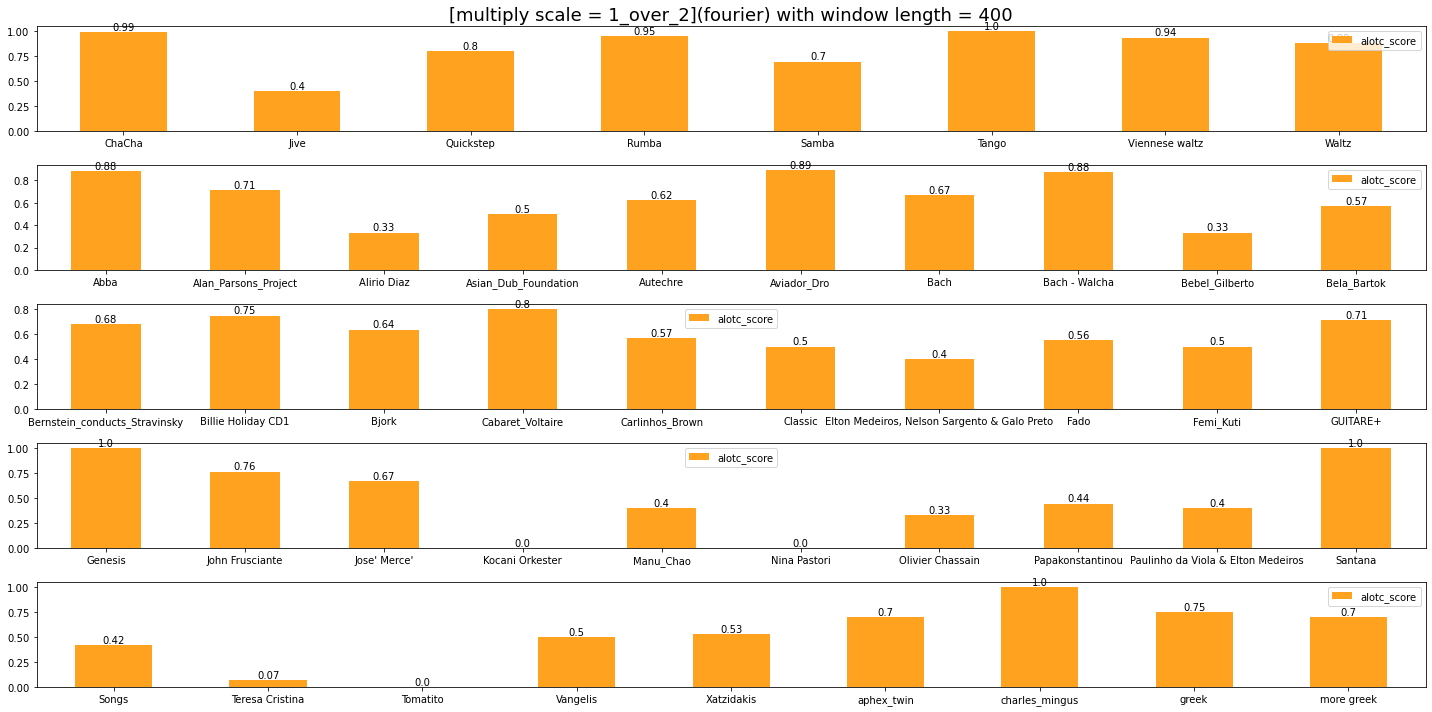

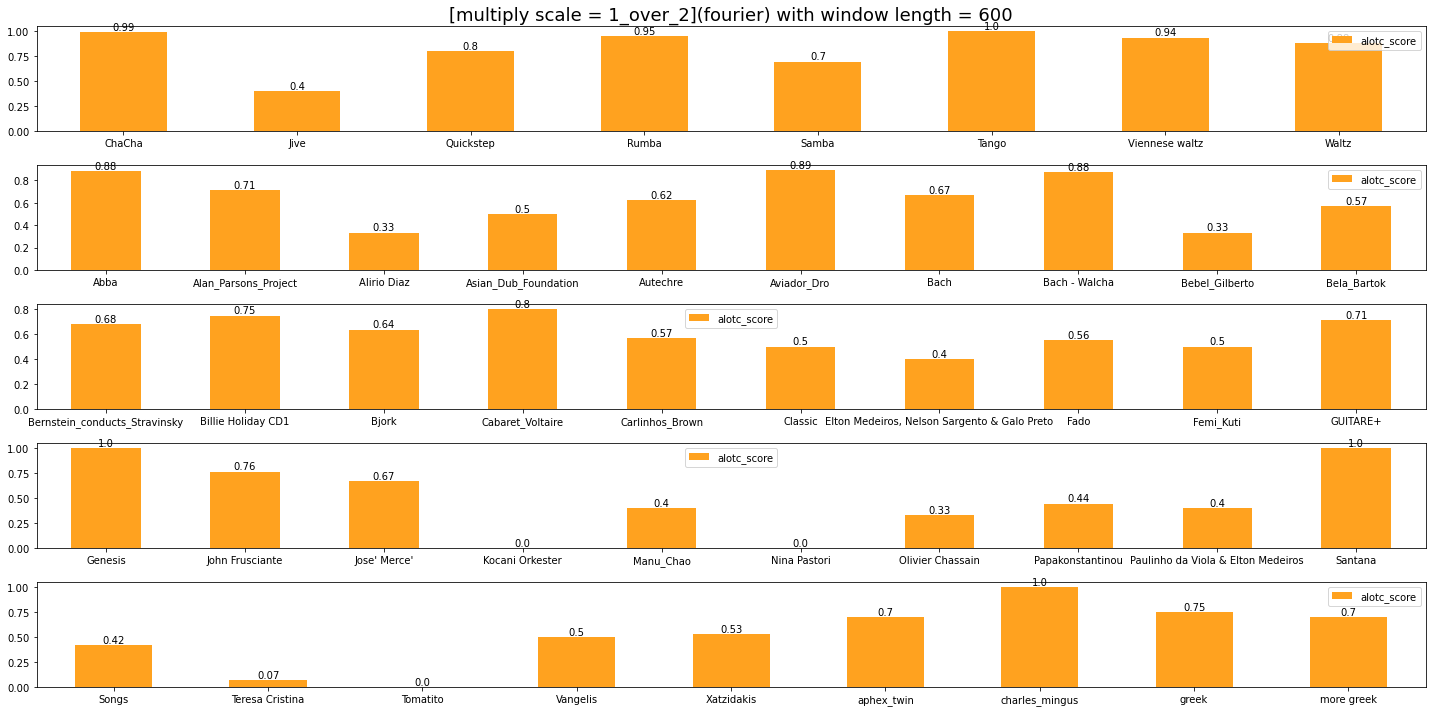

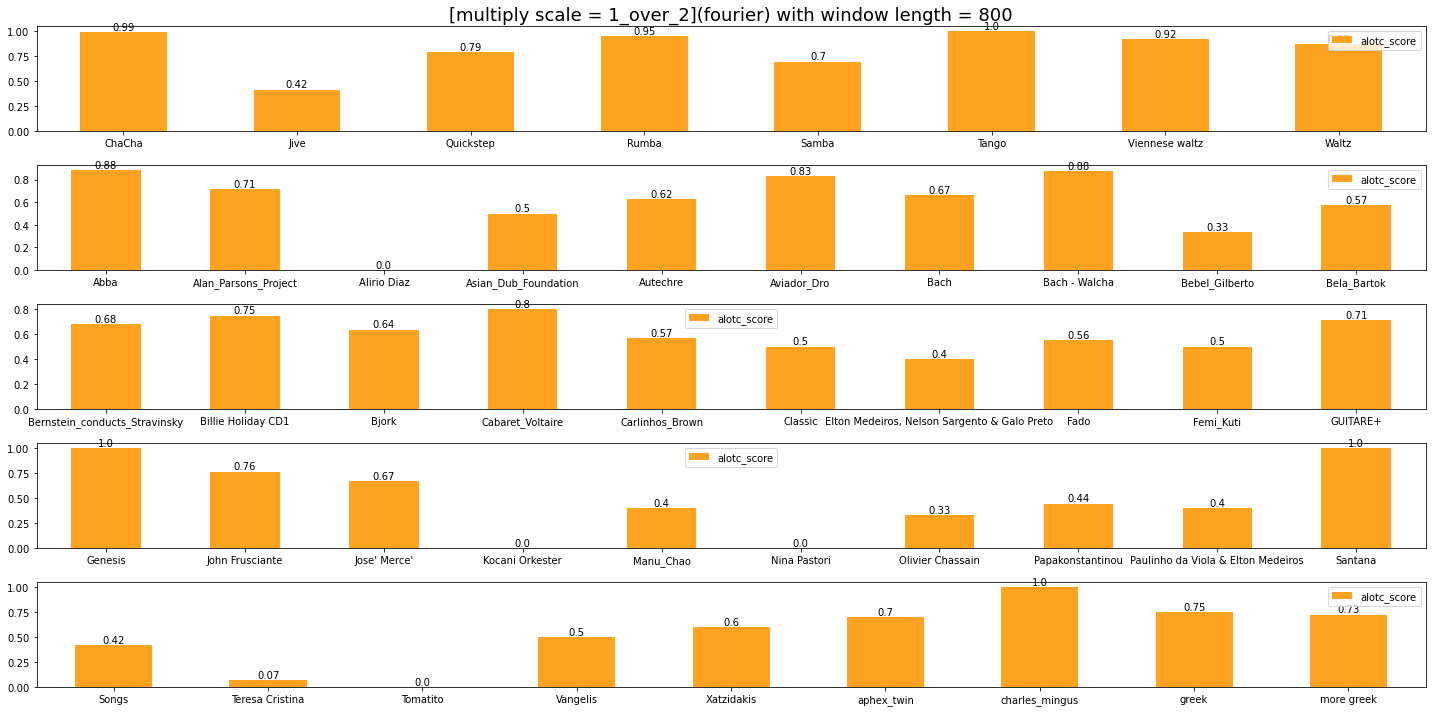

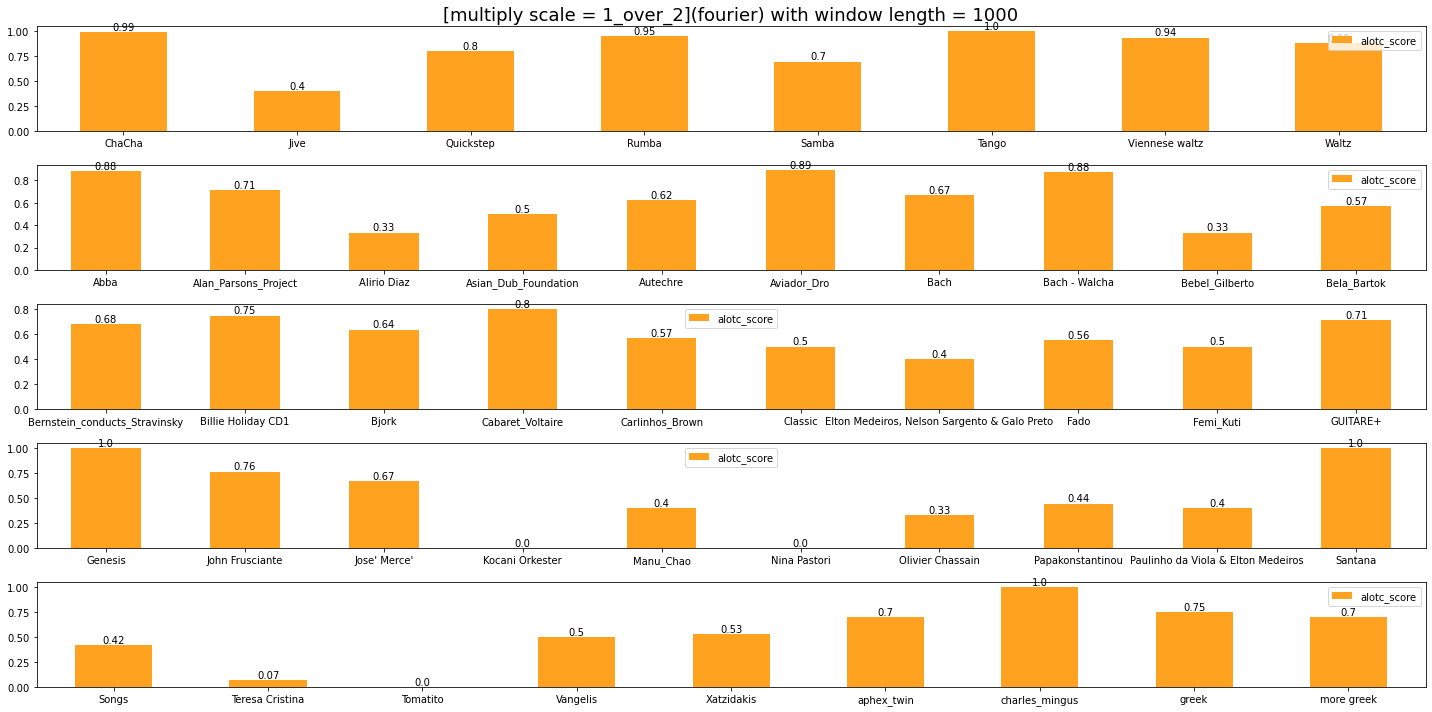

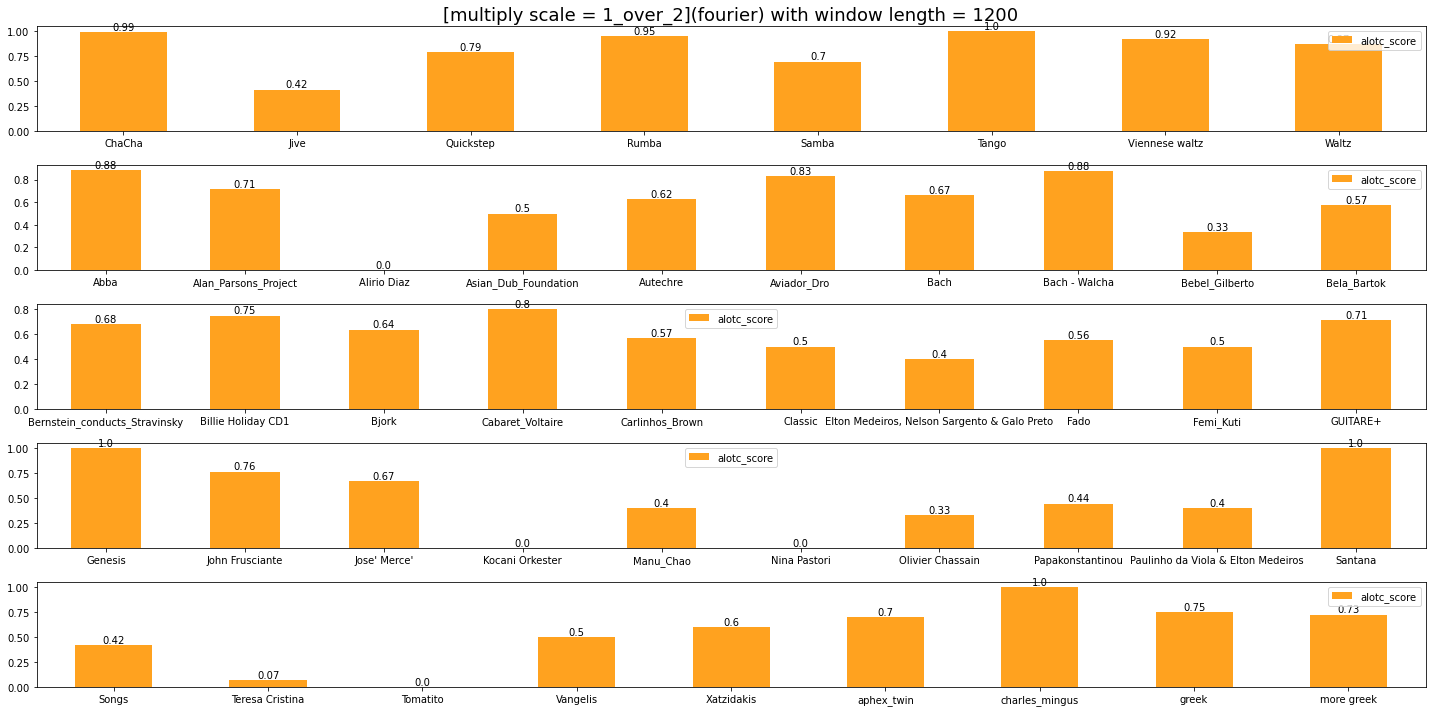

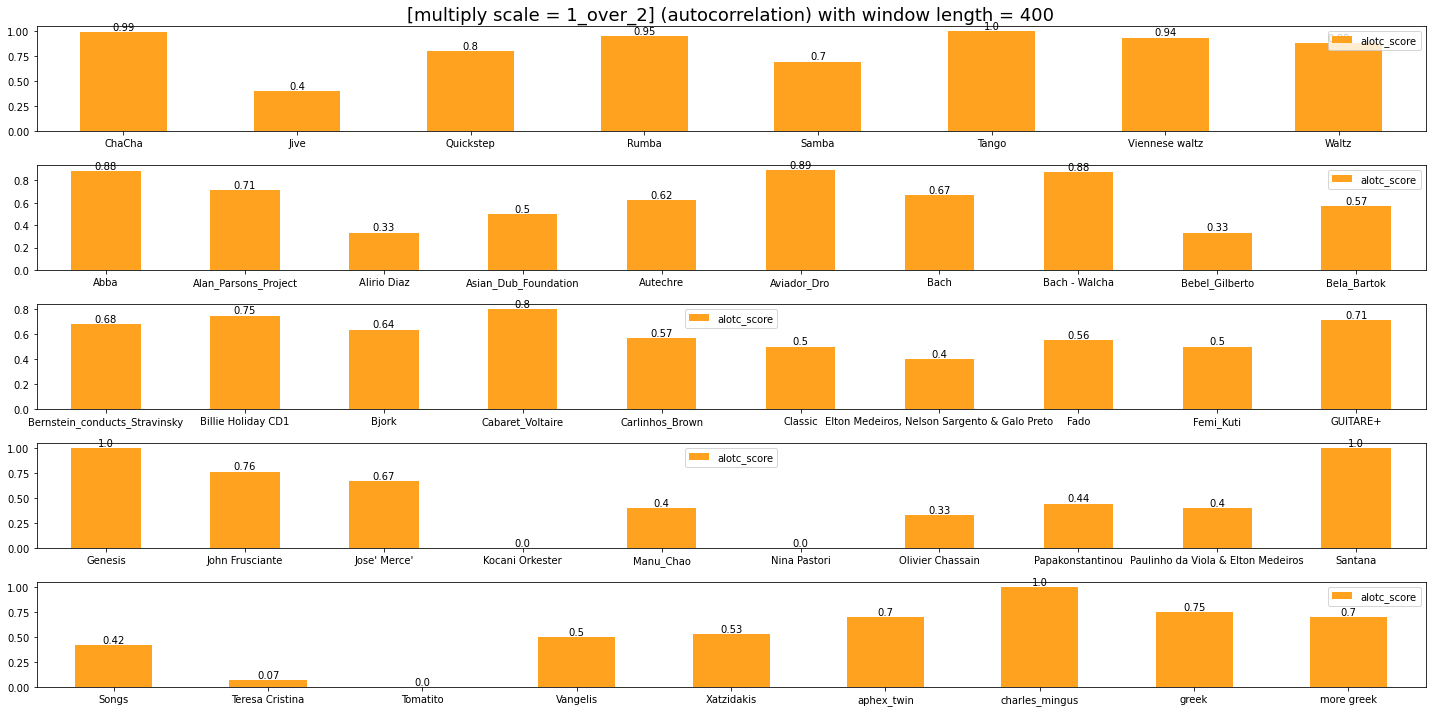

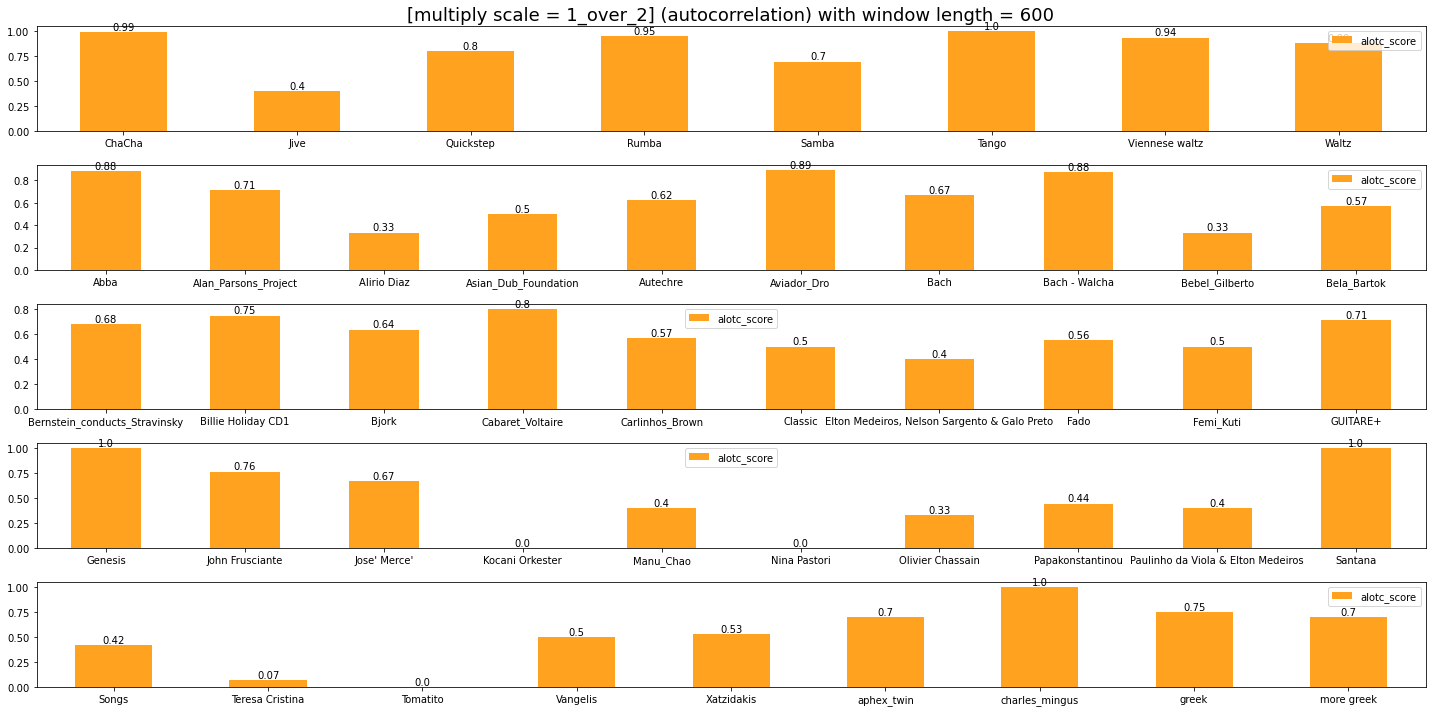

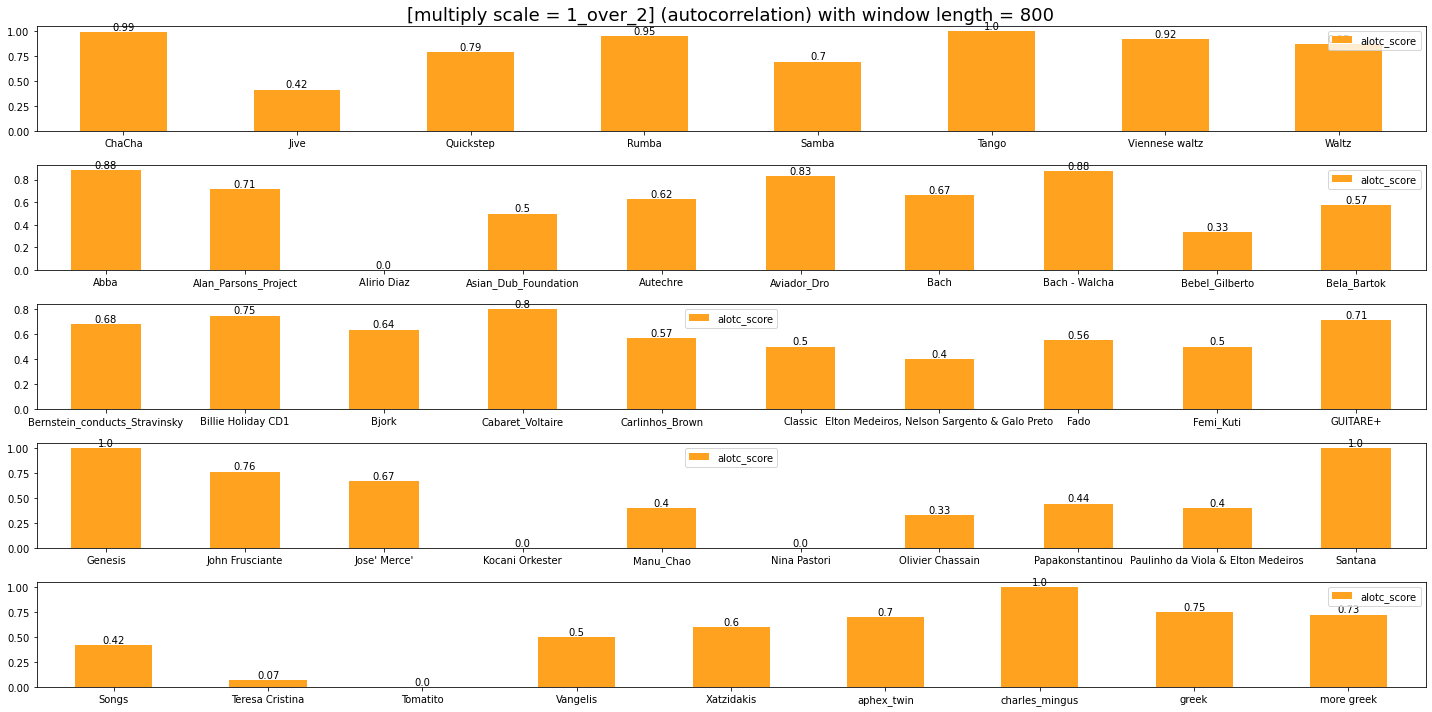

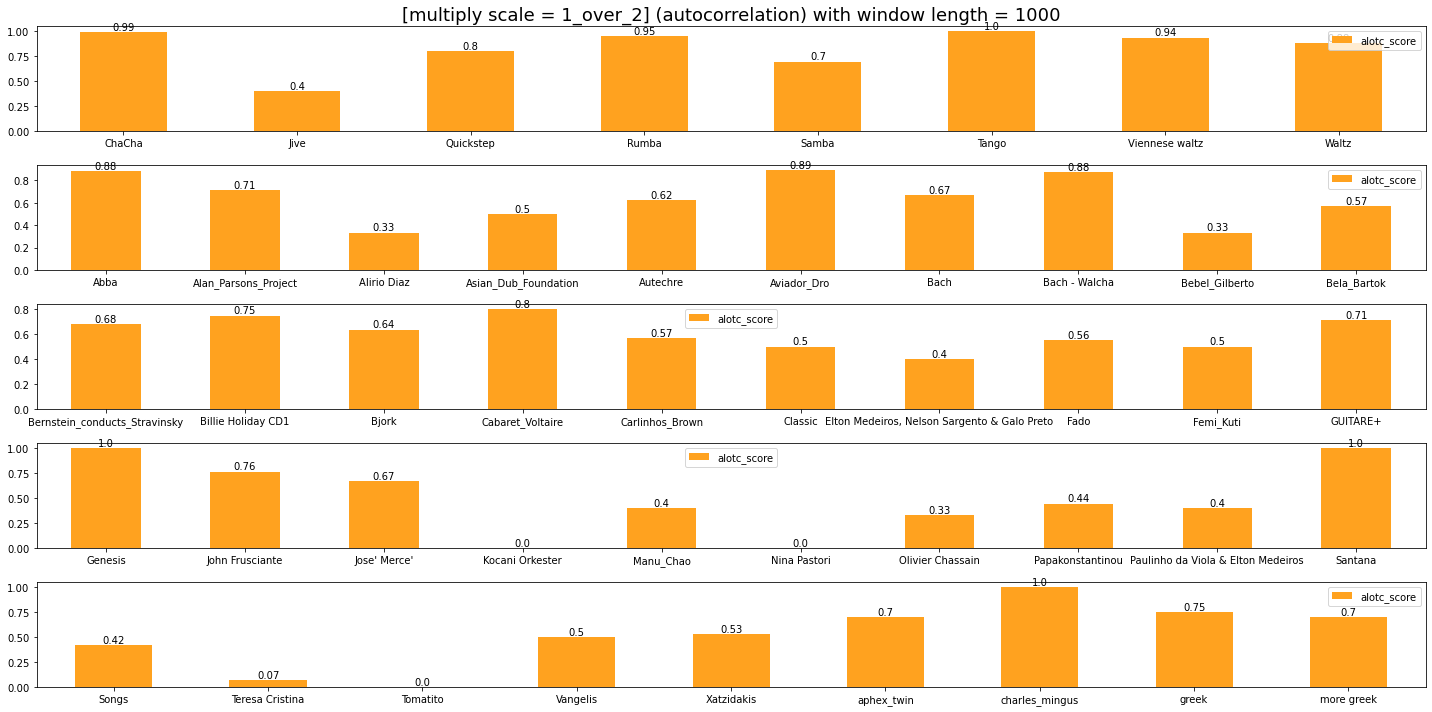

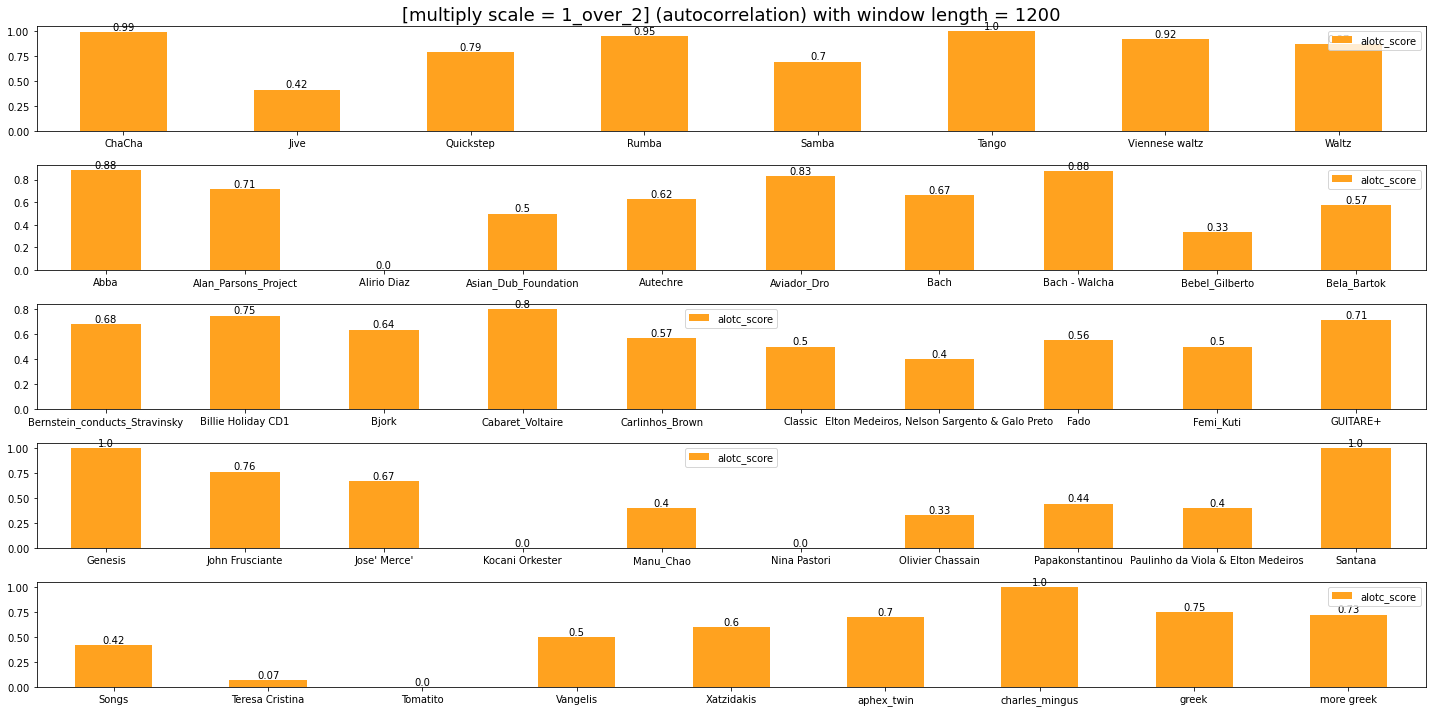

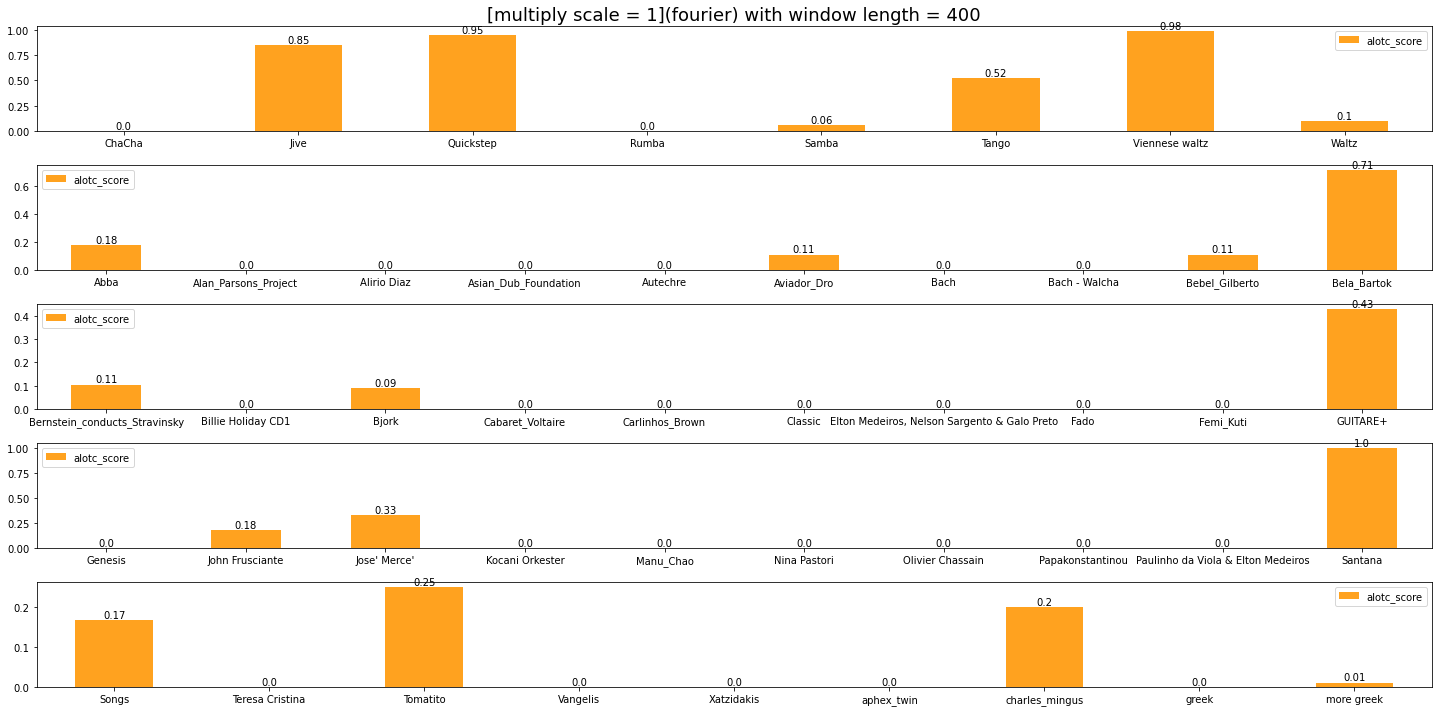

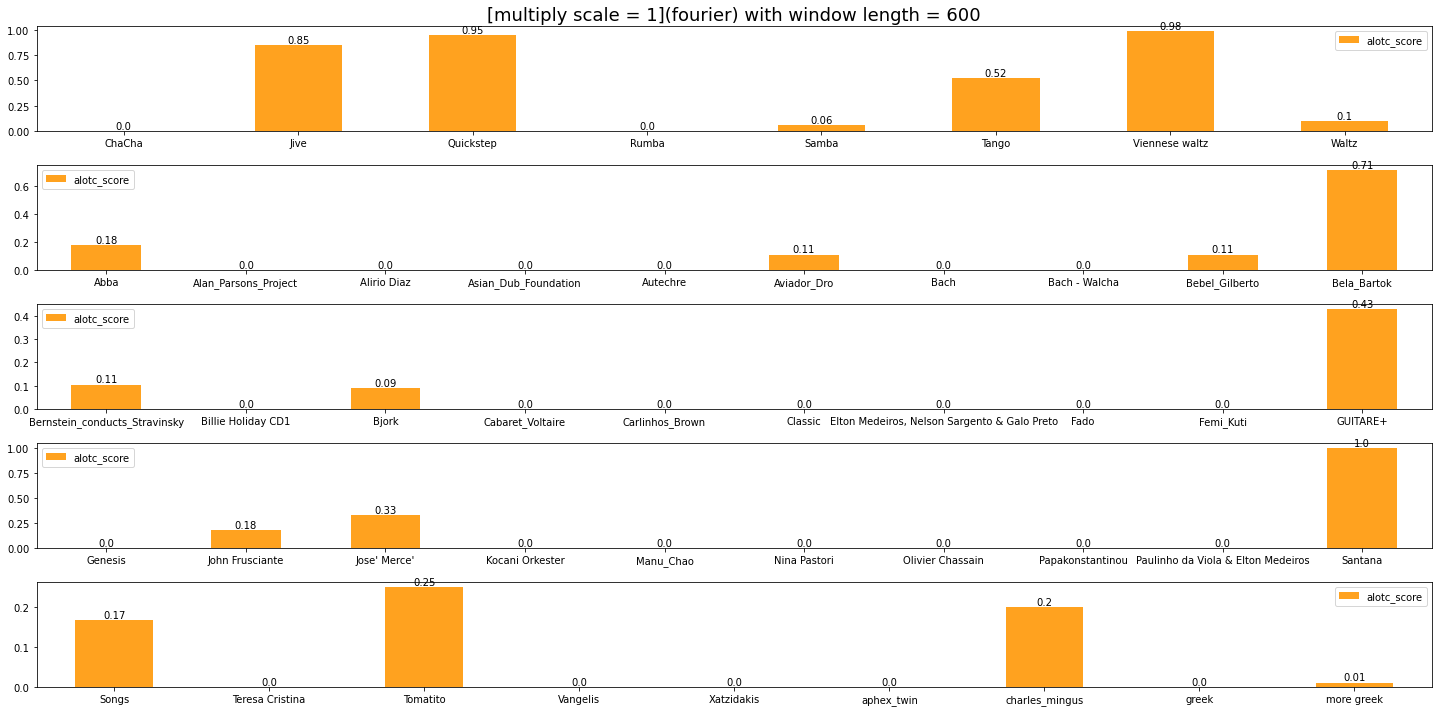

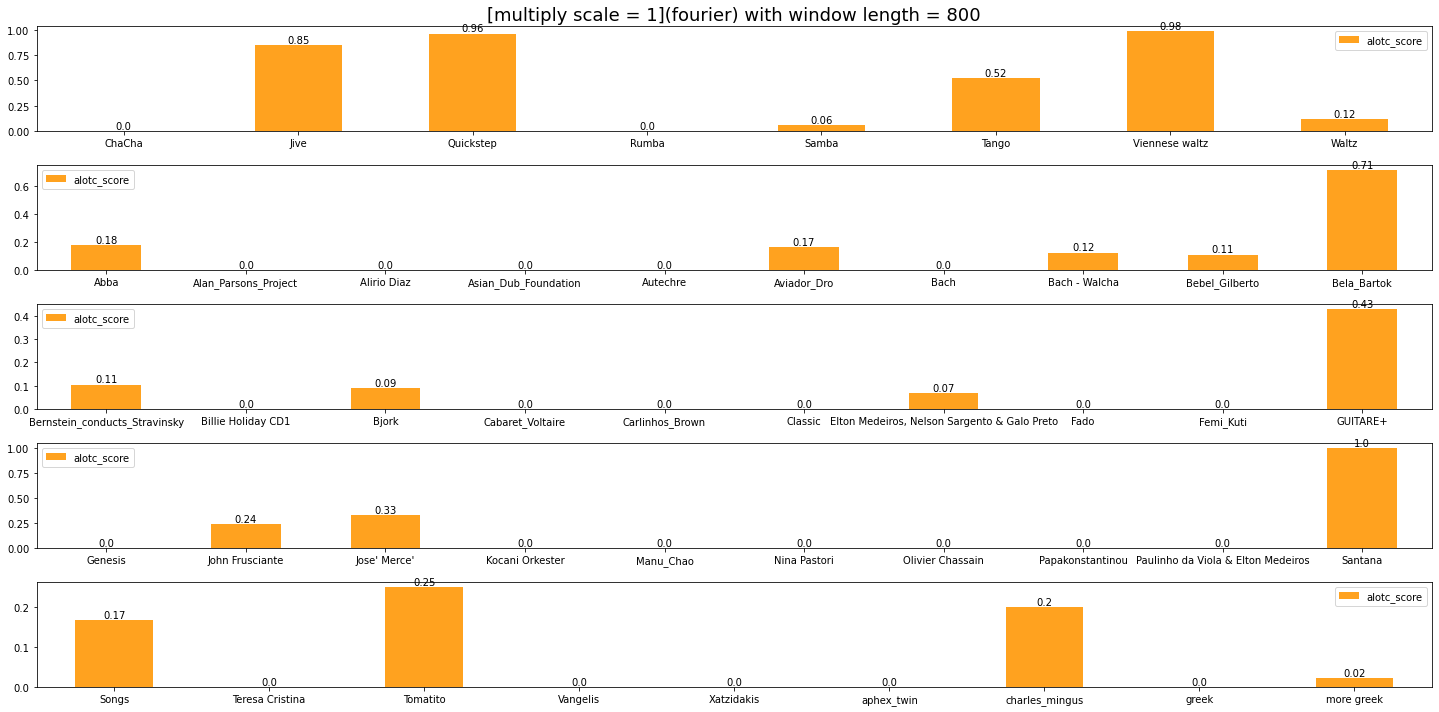

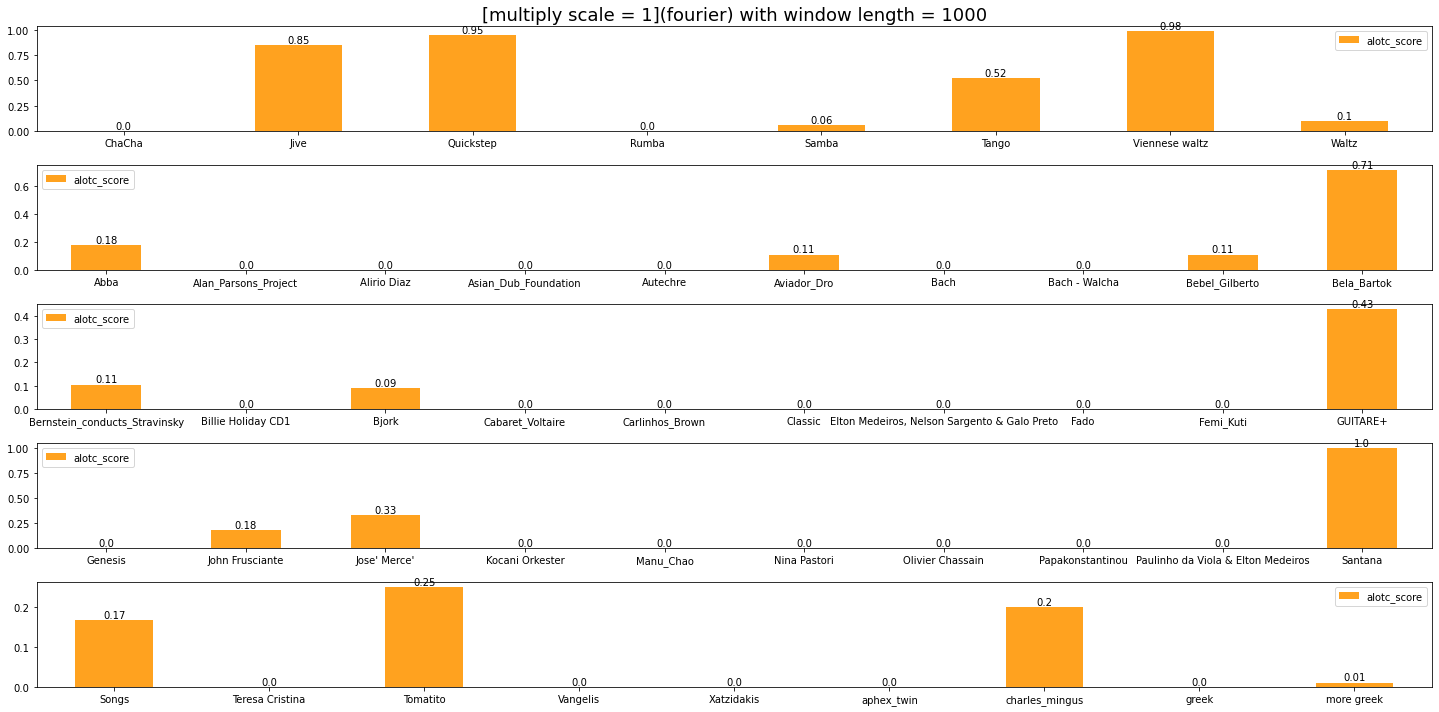

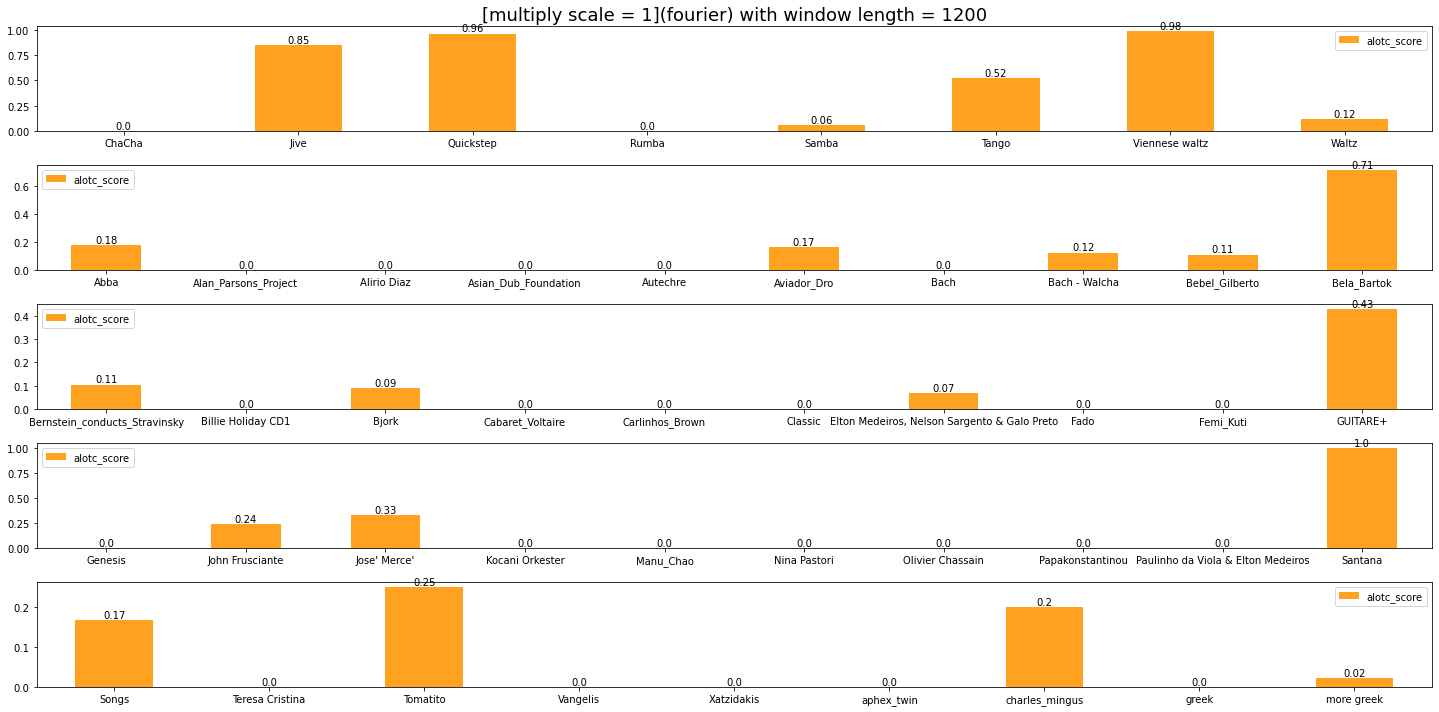

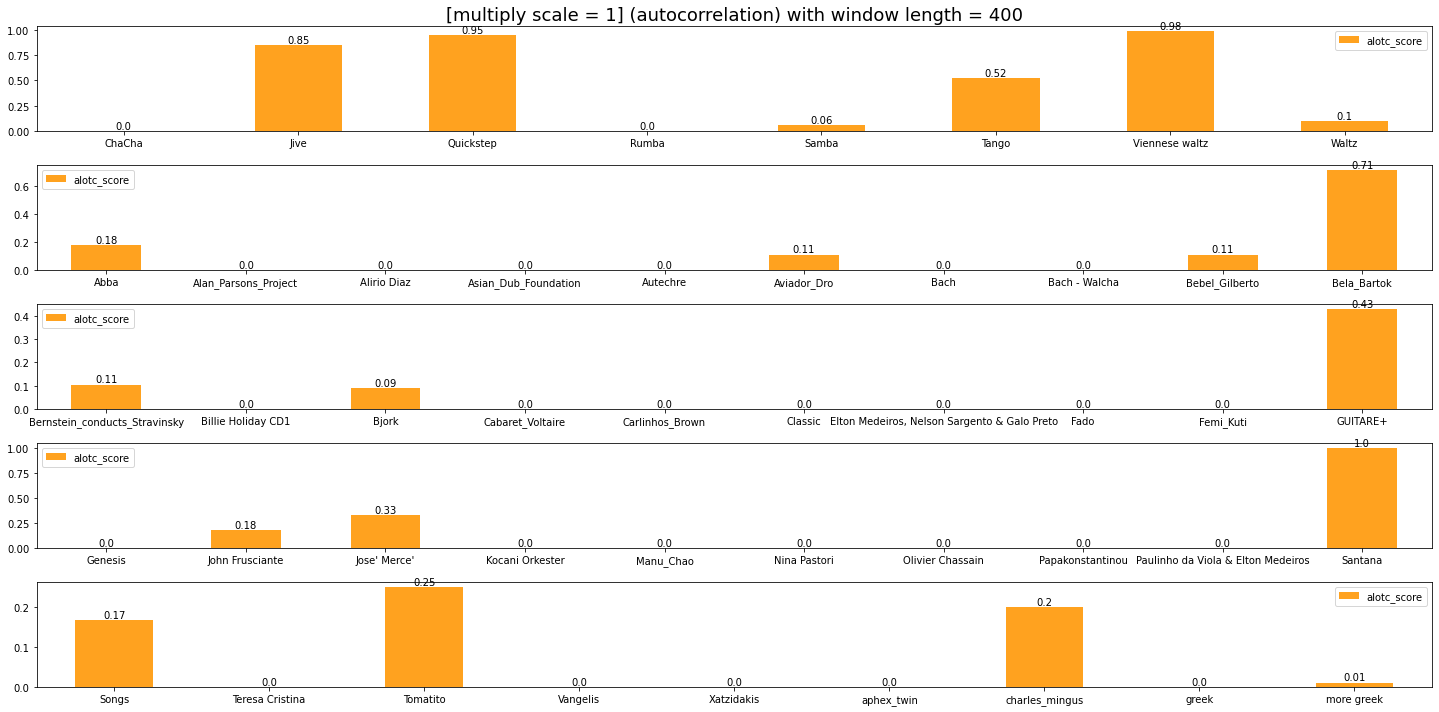

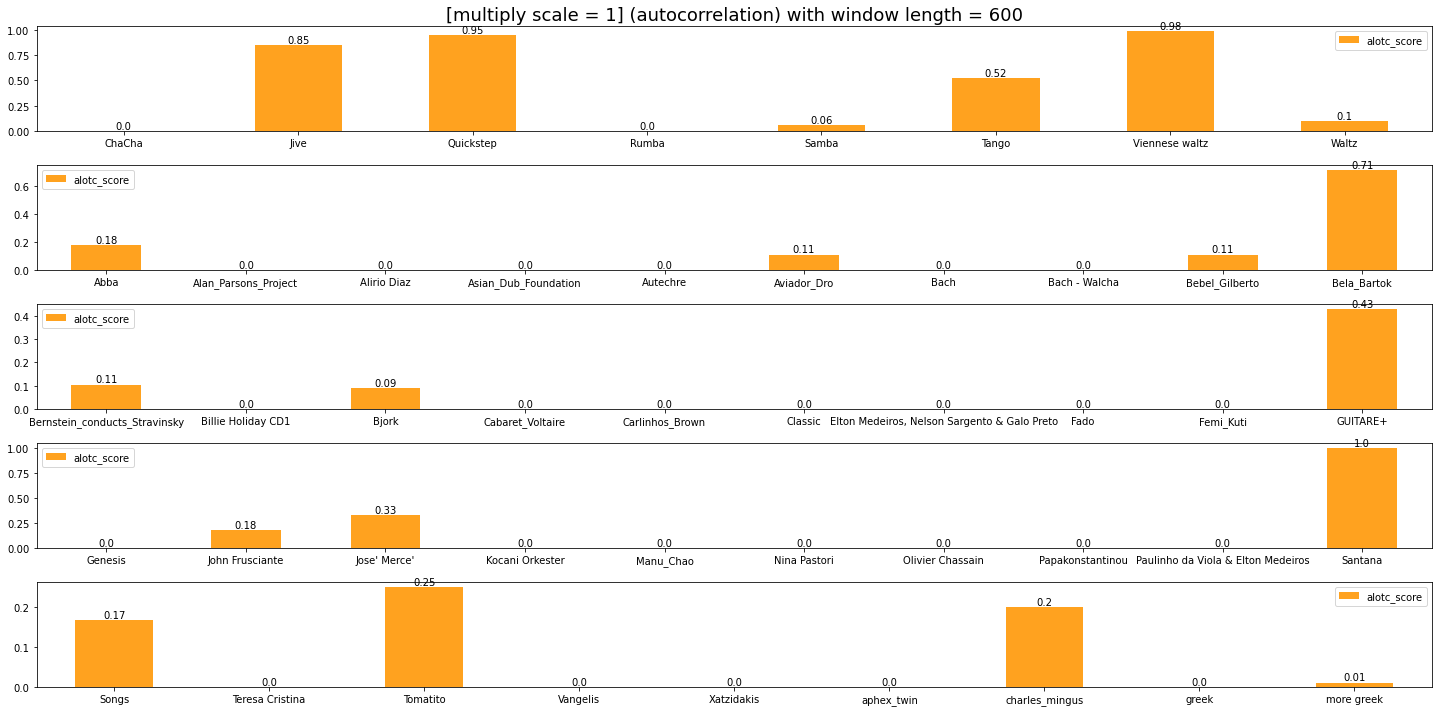

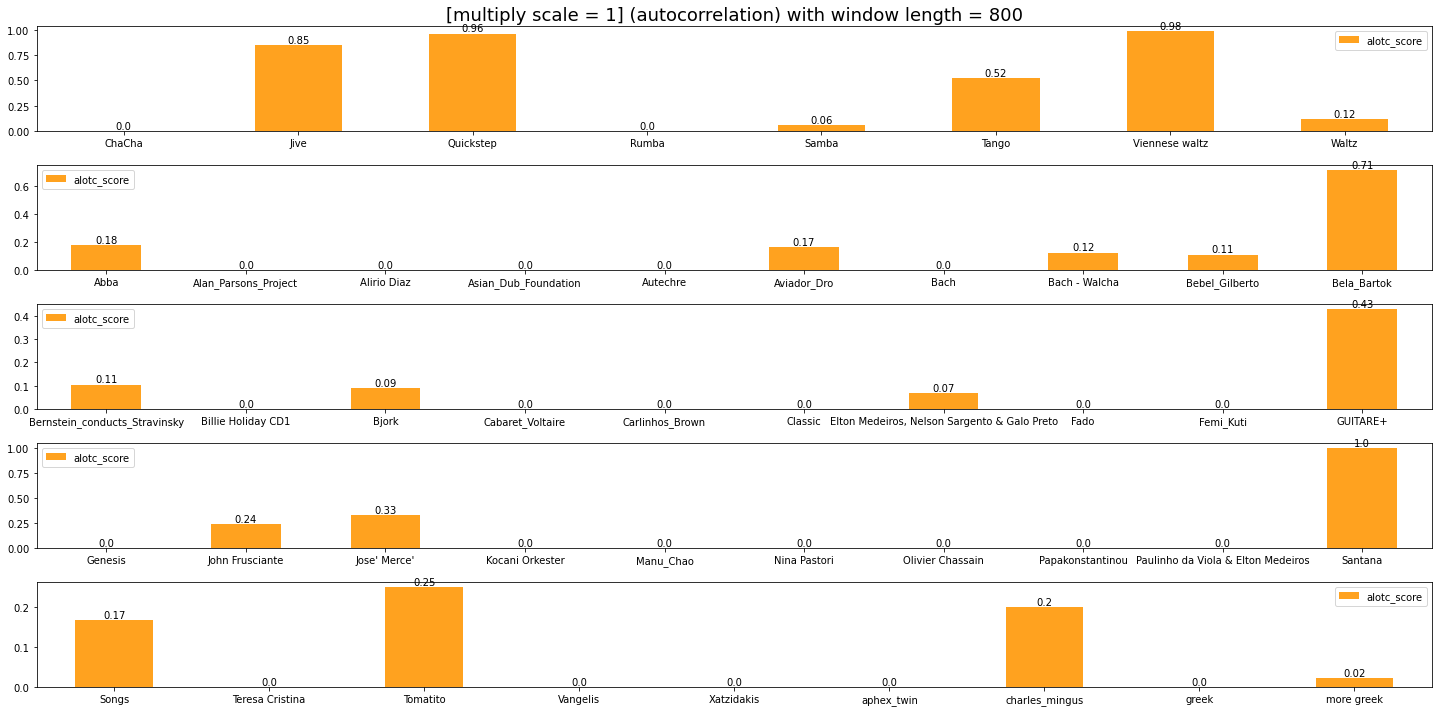

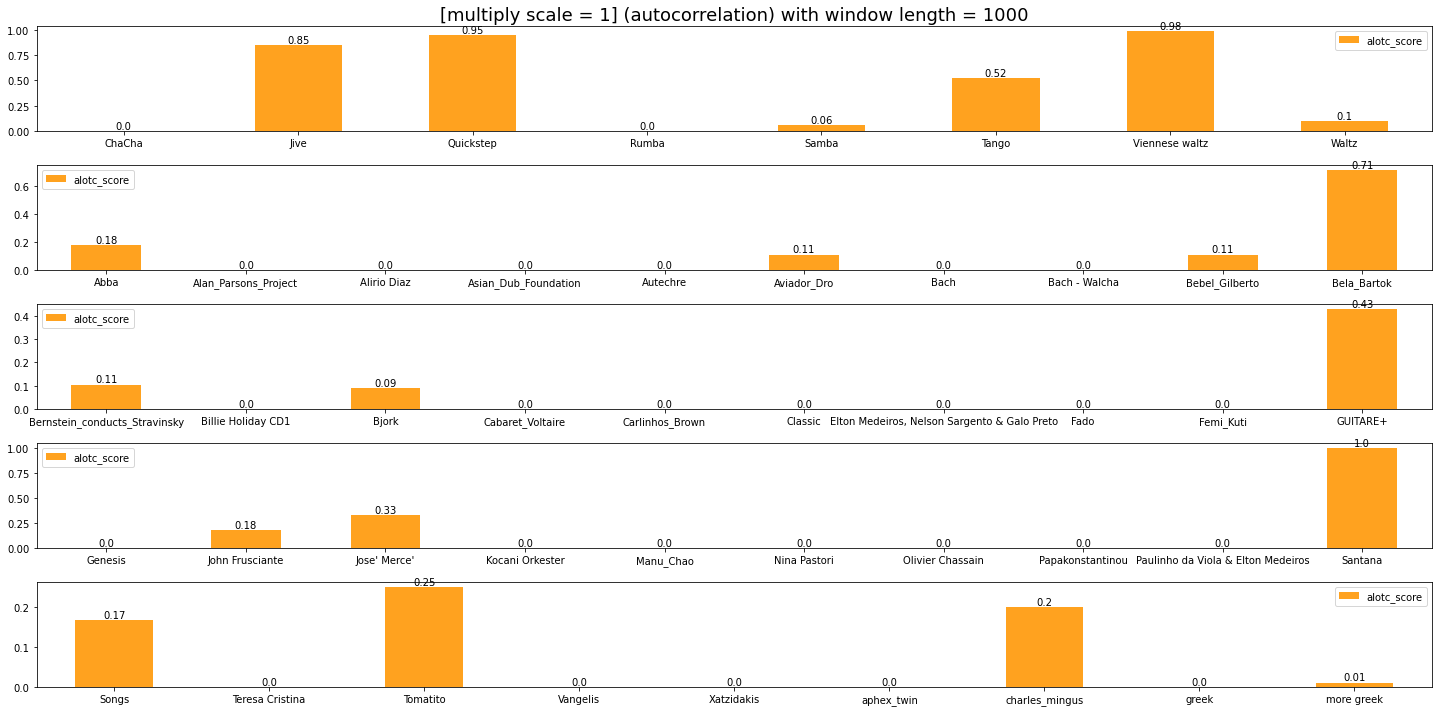

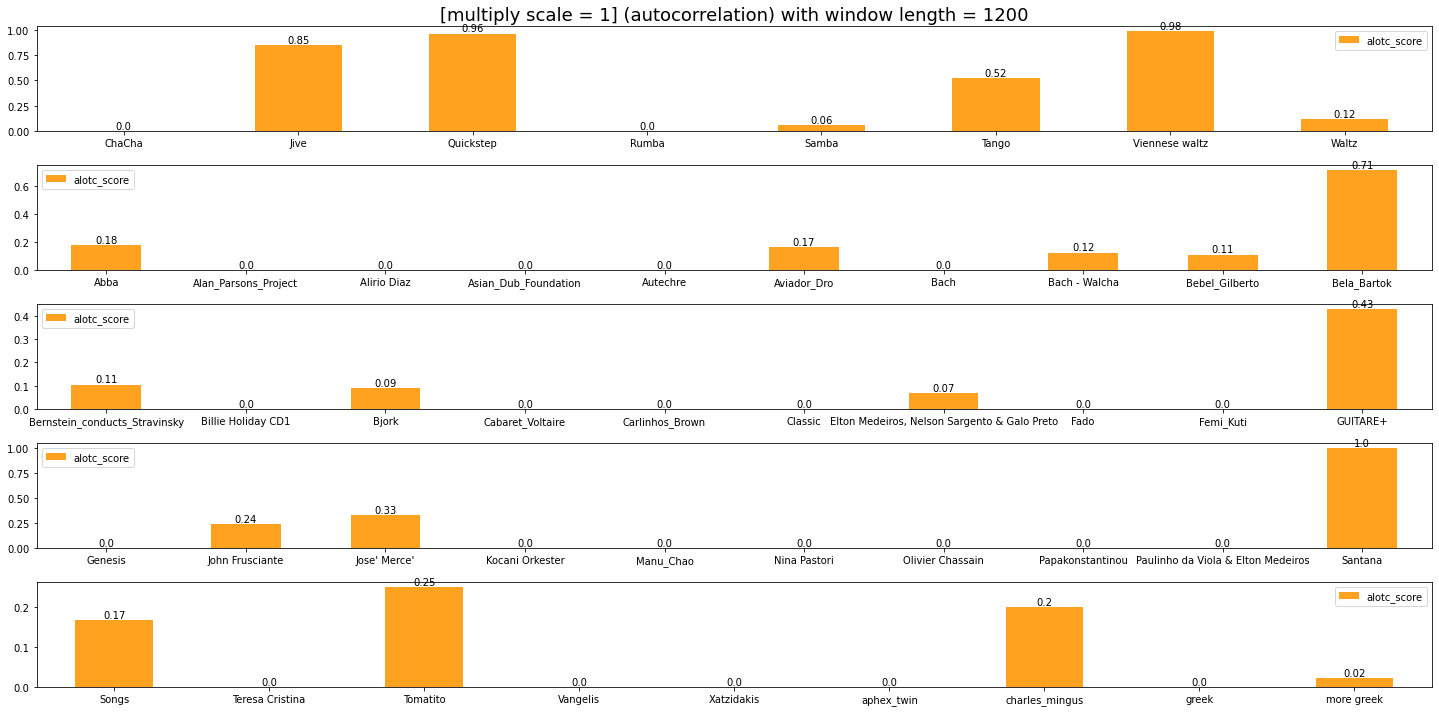

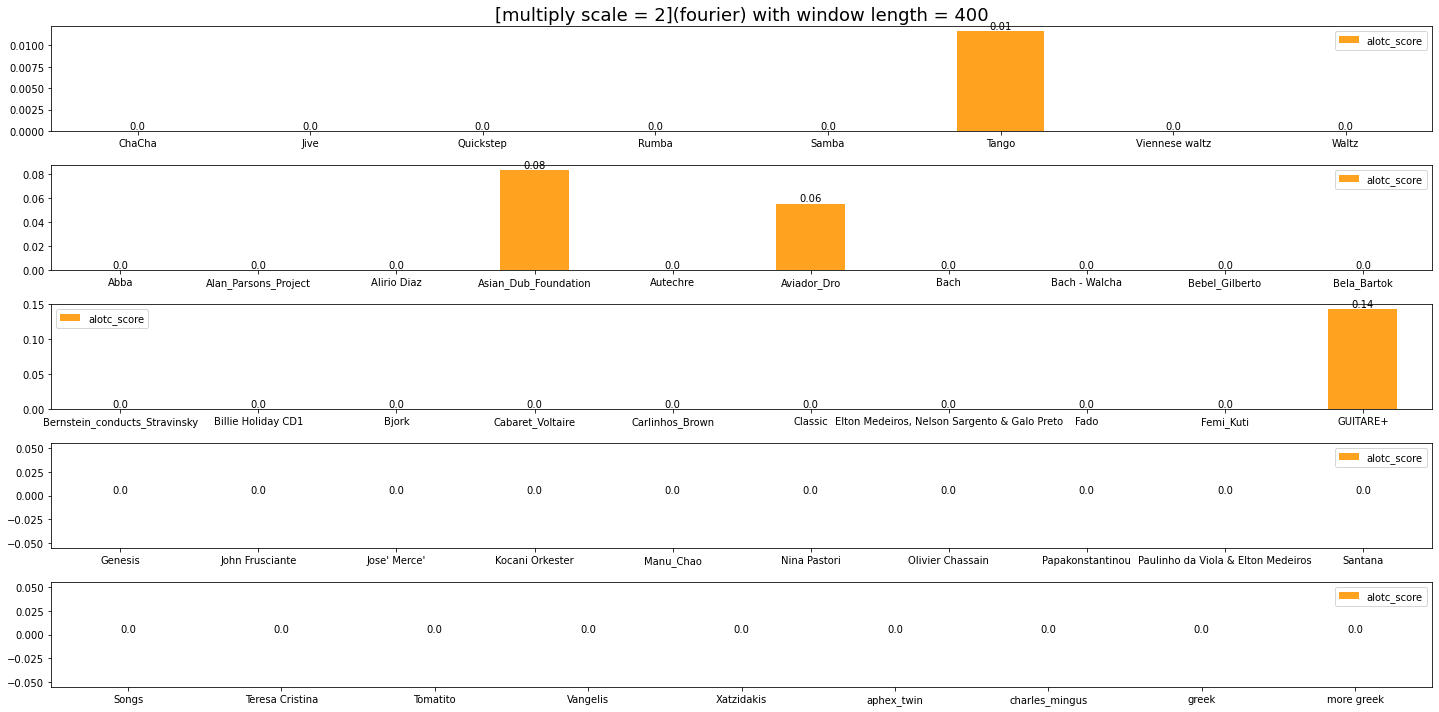

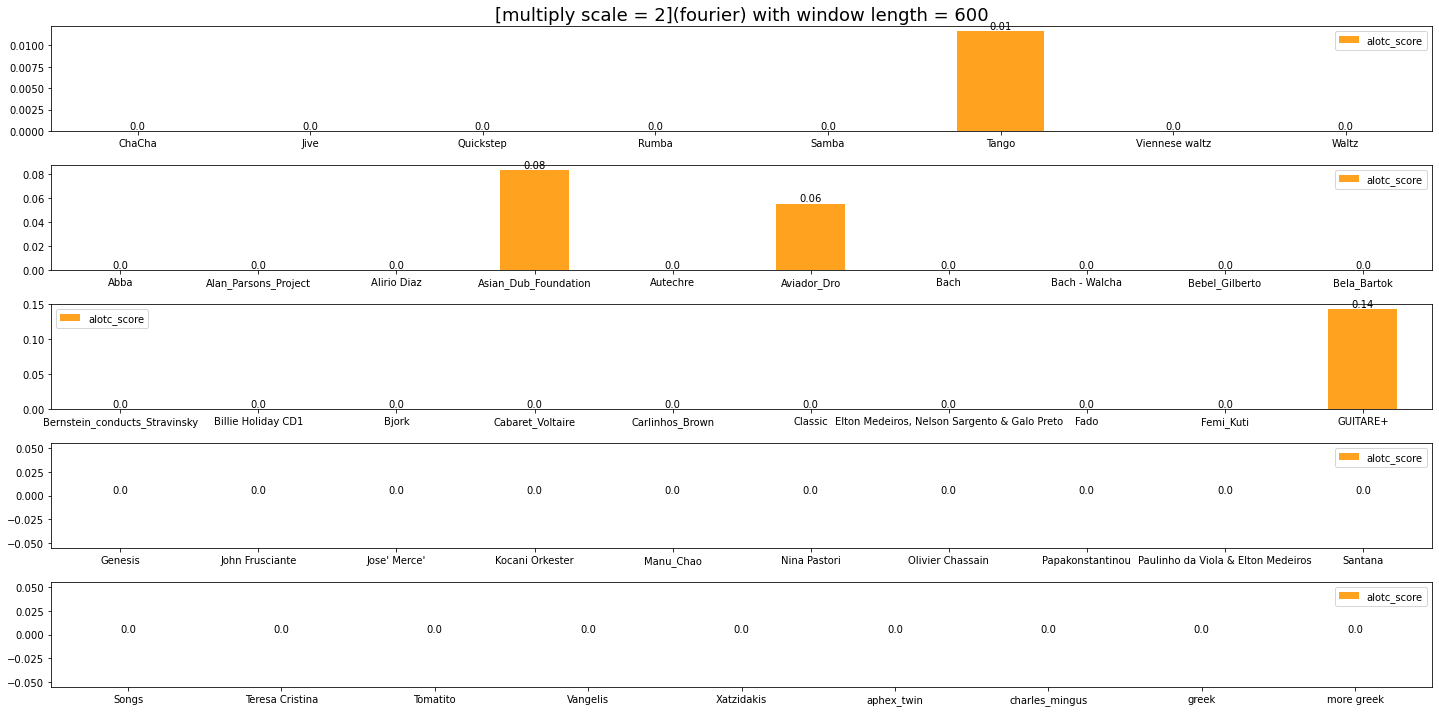

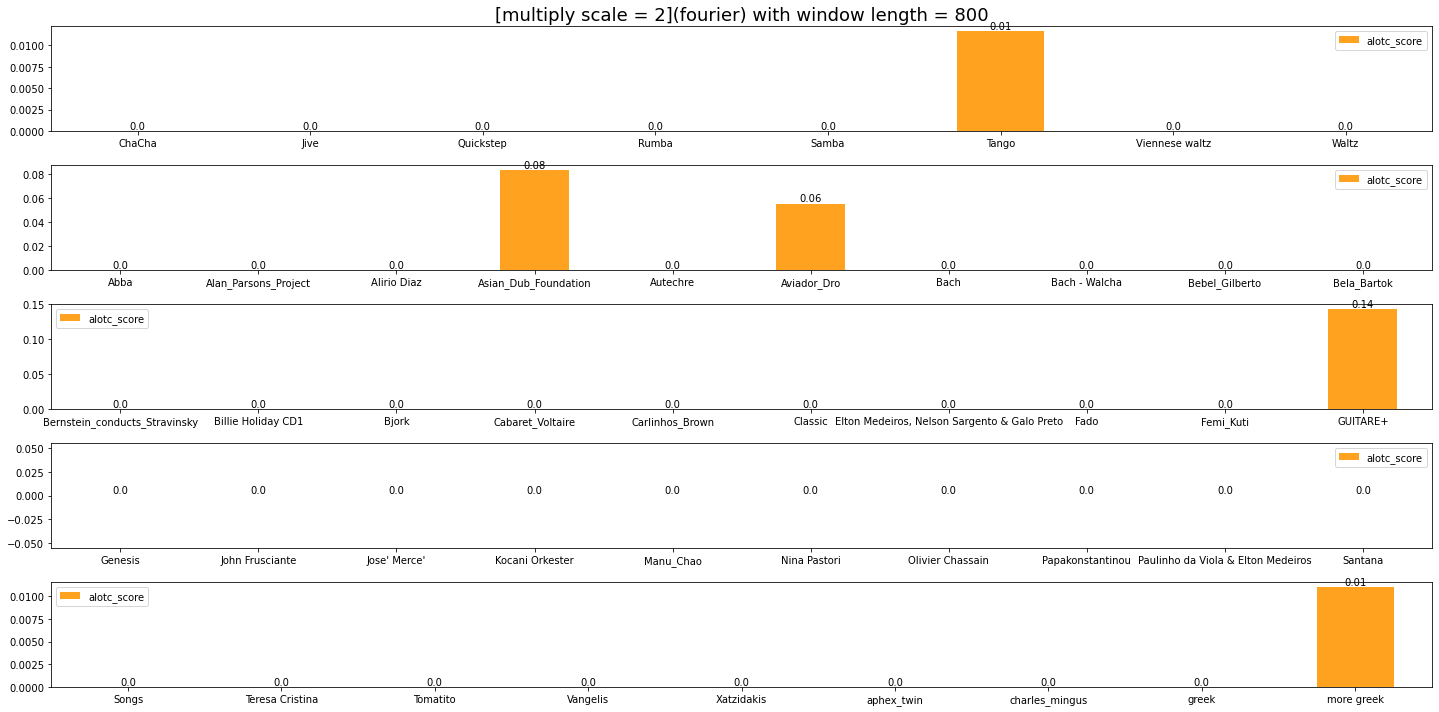

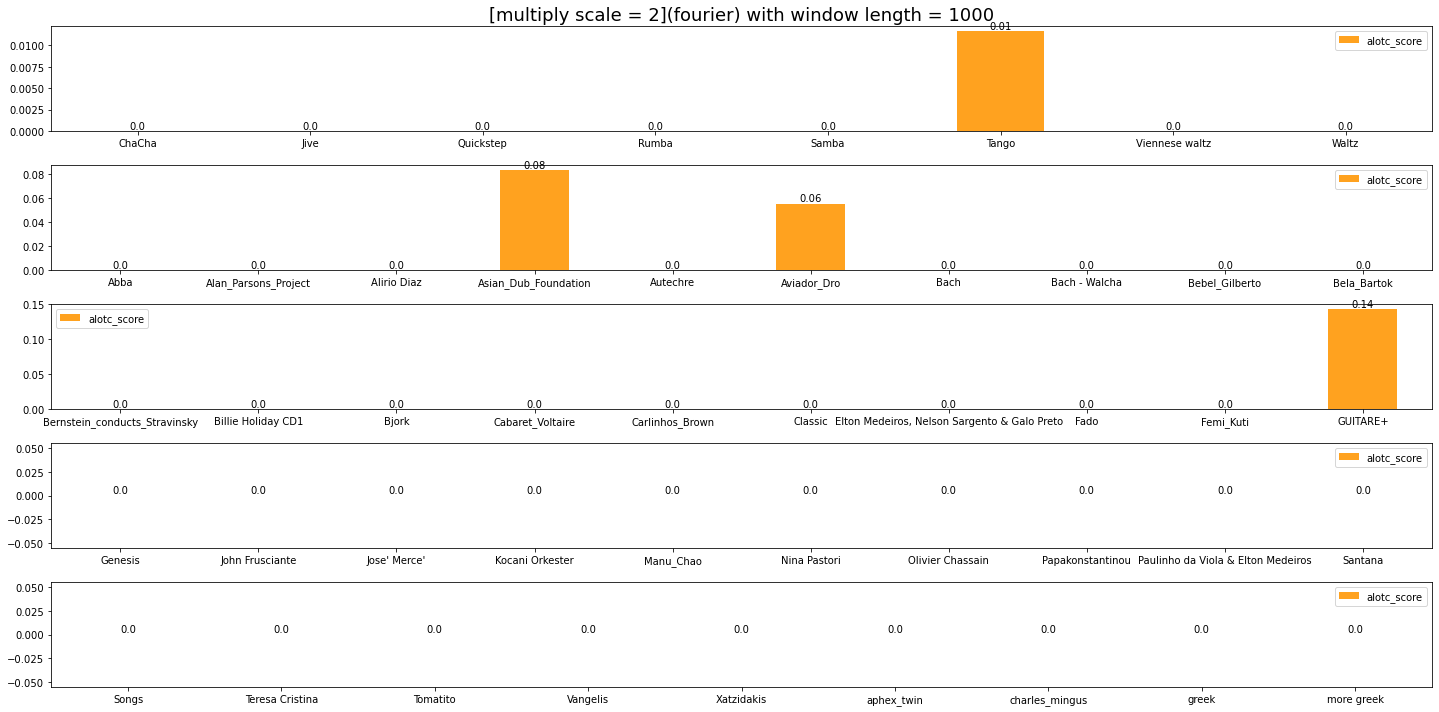

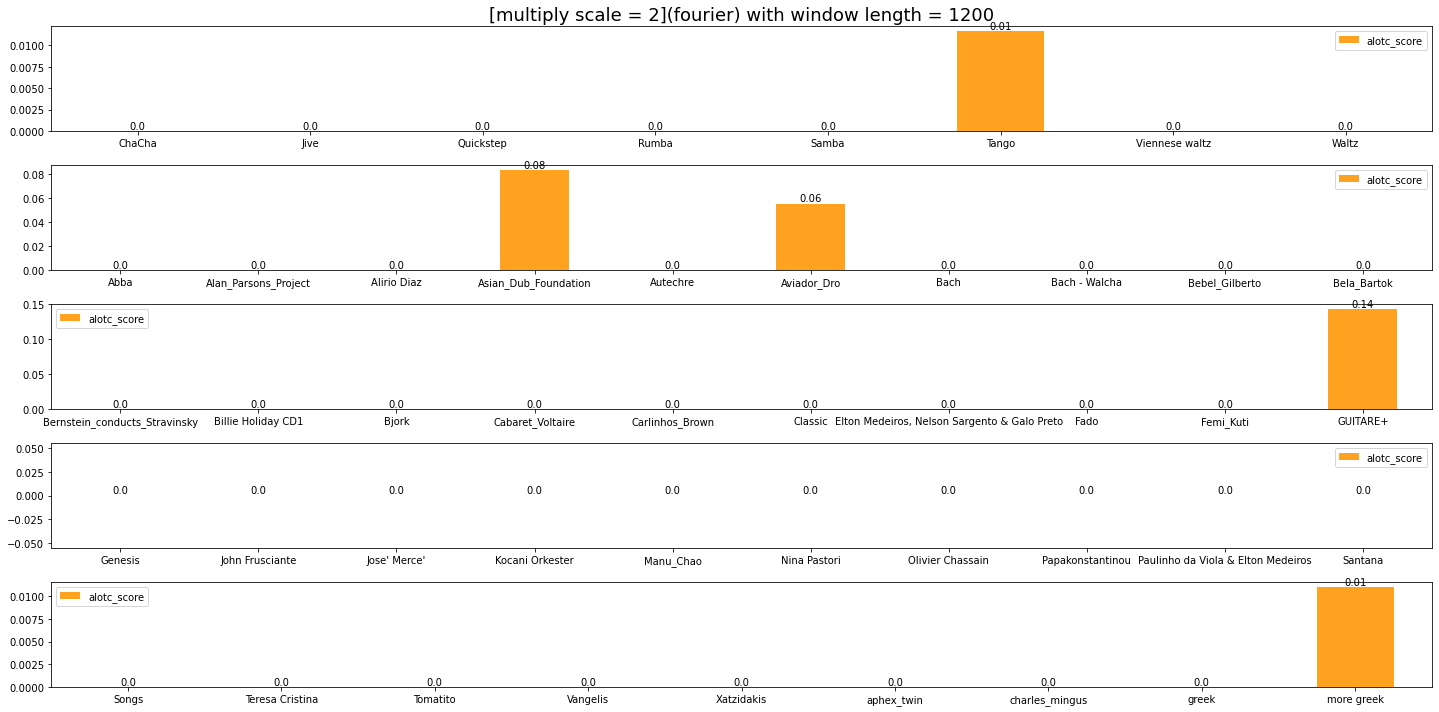

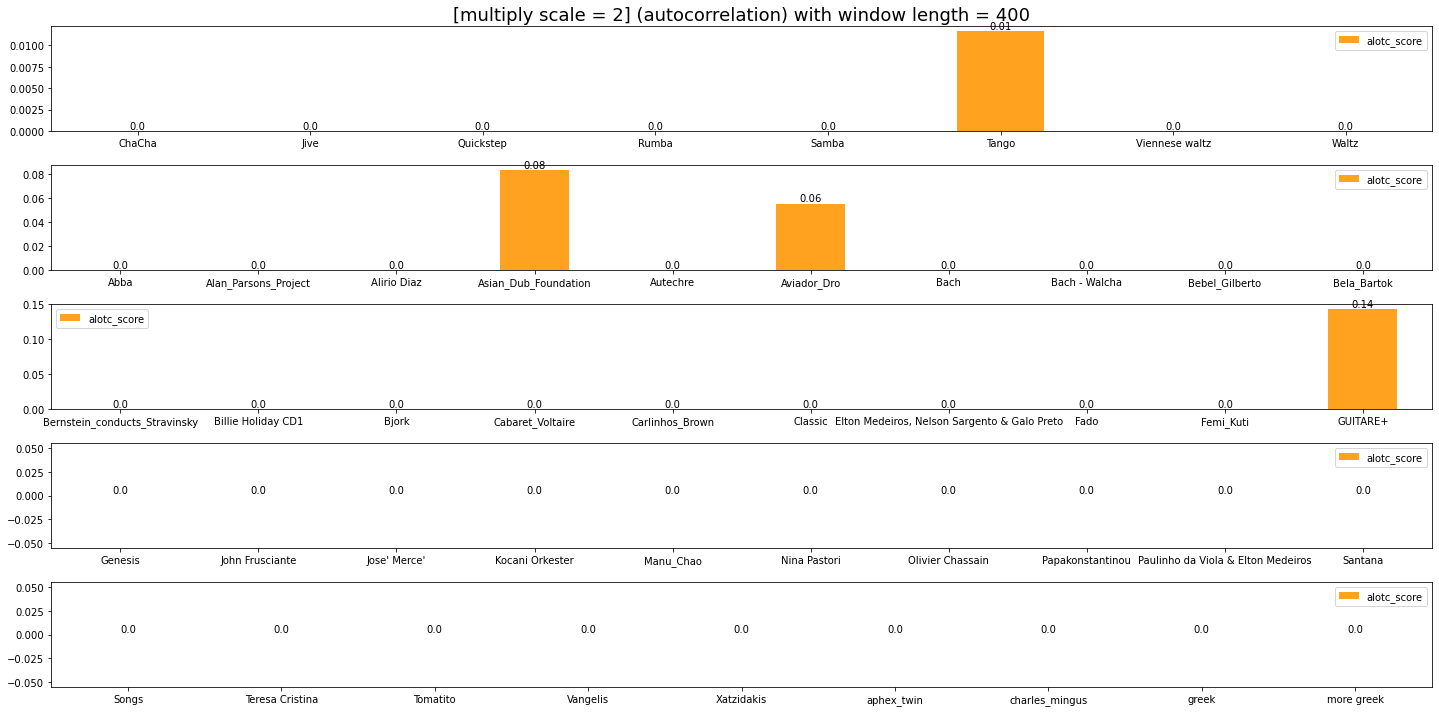

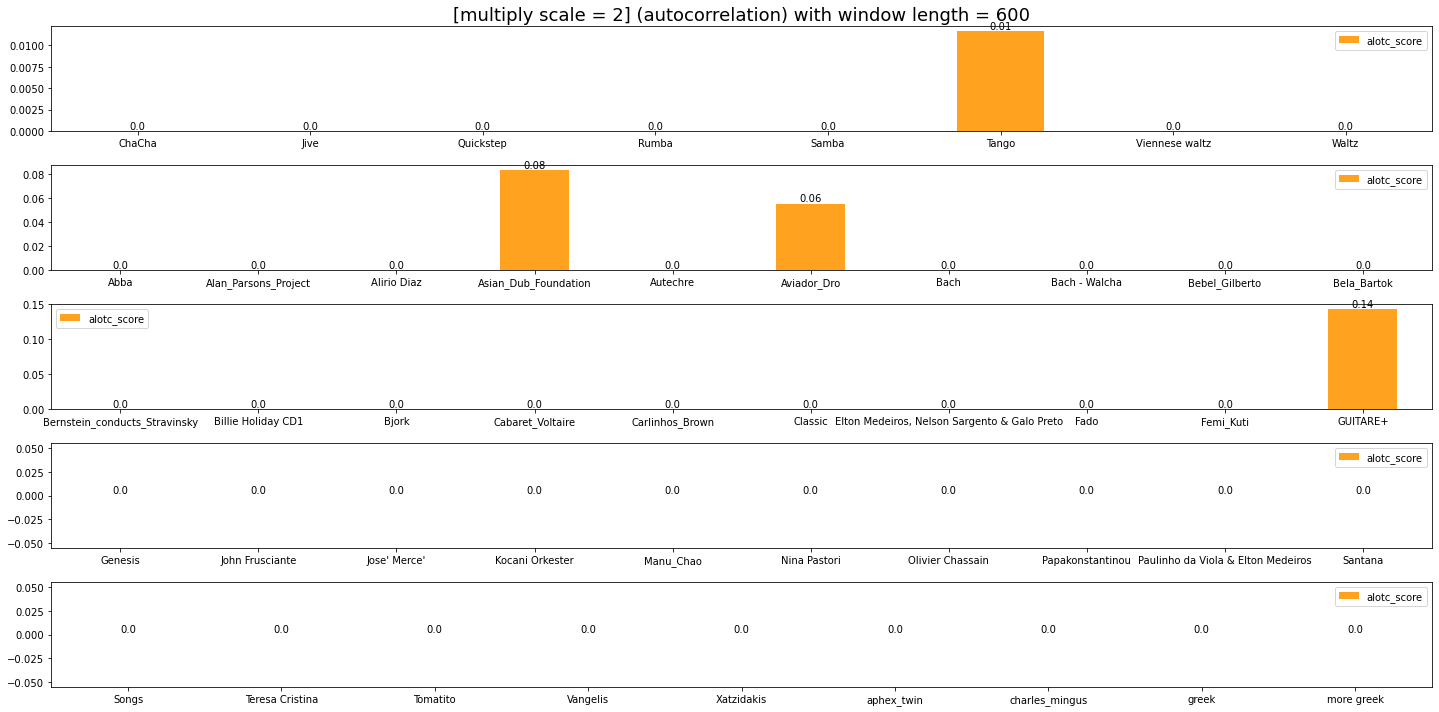

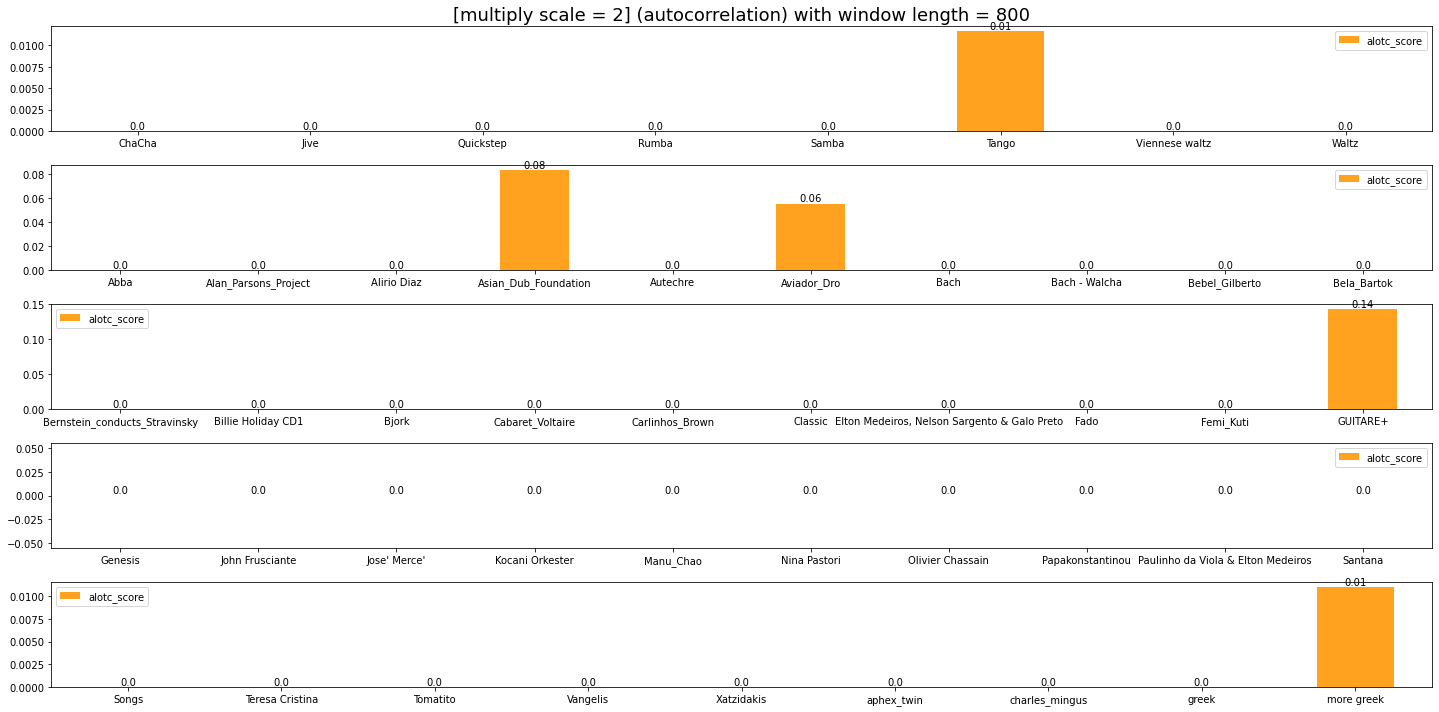

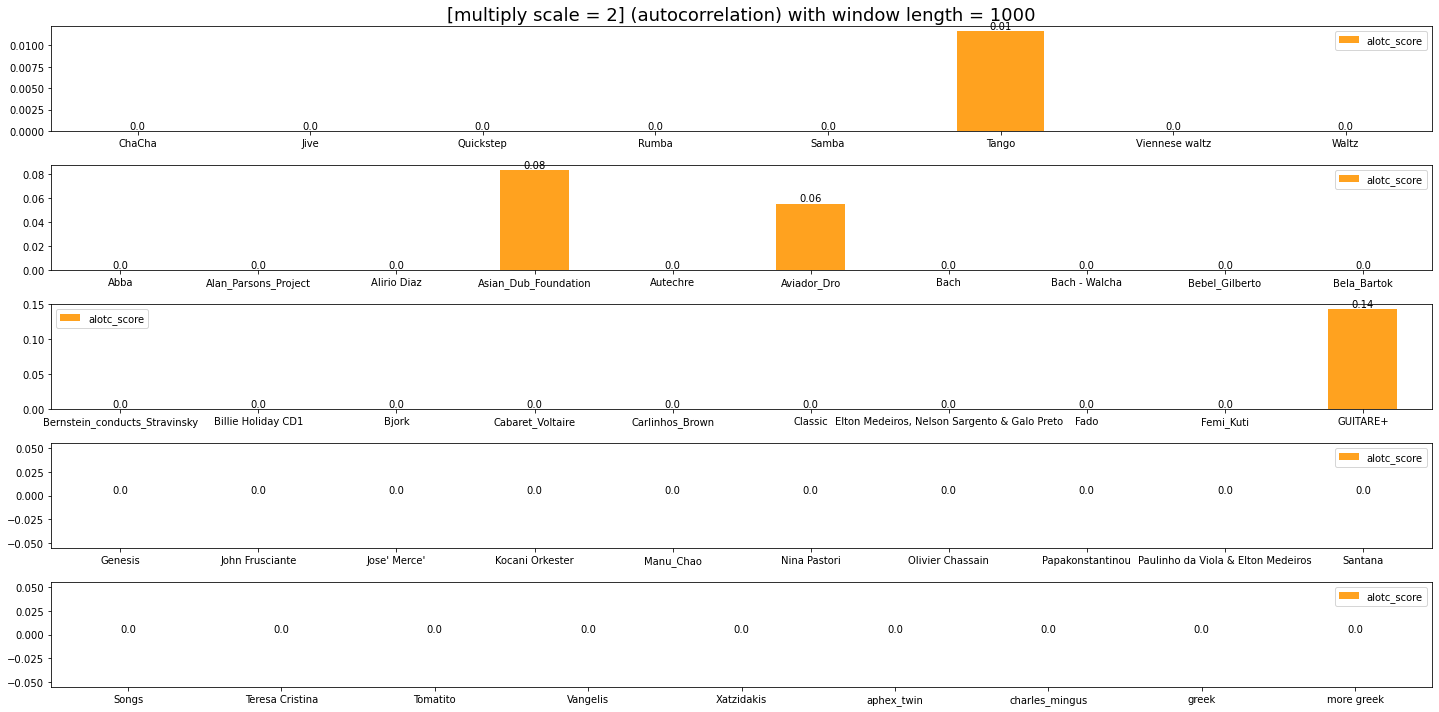

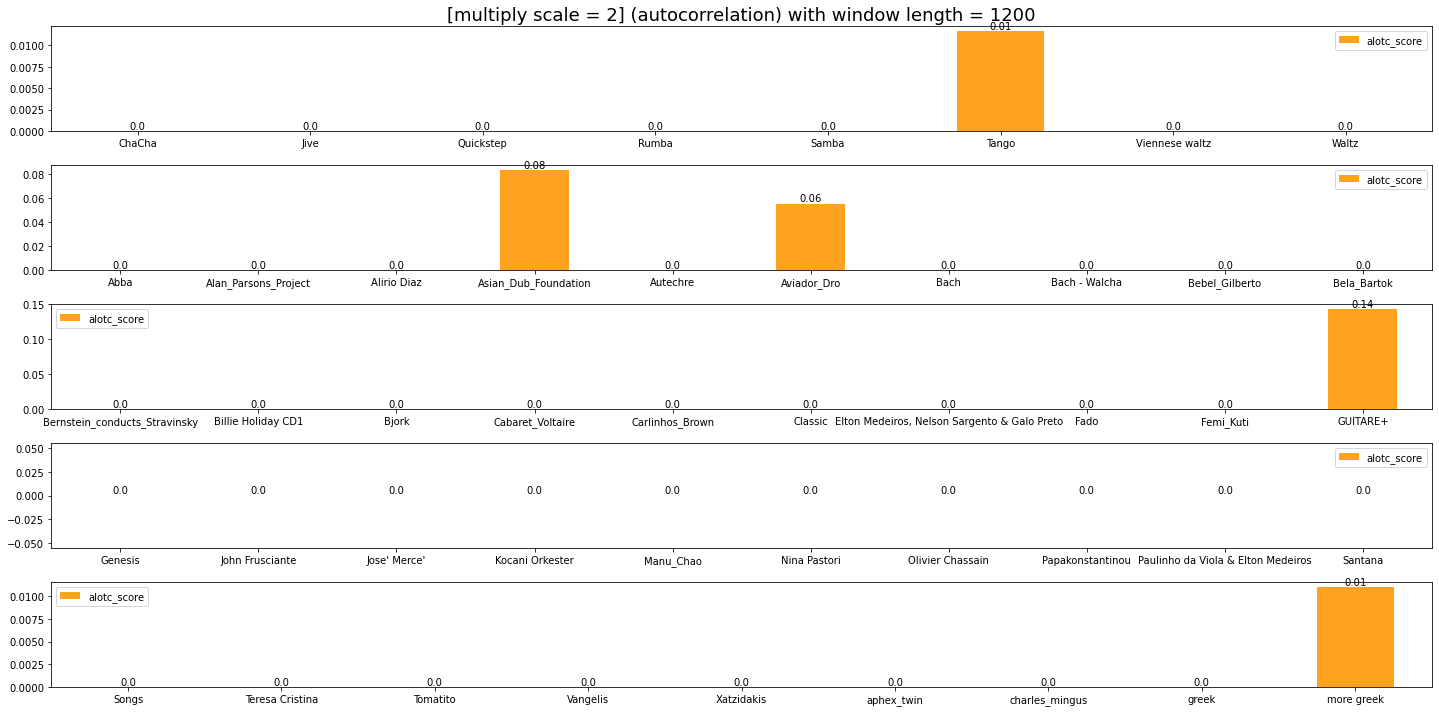

In [91]:
ballroom_score_dict_list_1over2 = [score_dict_400, score_dict_600, score_dict_800, score_dict_1000, score_dict_1200]
ballroom_score_dict_list_1 = [score_dict_400_1, score_dict_600_1, score_dict_800_1, score_dict_1000_1, score_dict_1200_1]
ballroom_score_dict_list_2 = [score_dict_400_2, score_dict_600_2, score_dict_800_2, score_dict_1000_2, score_dict_1200_2]

ismir_score_dict_list_1 = [ismir_score_dict_400, ismir_score_dict_600, ismir_score_dict_800, ismir_score_dict_1000, ismir_score_dict_1200]
ismir_score_dict_list_1over2 = [ismir_score_dict_400_1over2, ismir_score_dict_600_1over2, ismir_score_dict_800_1over2, ismir_score_dict_1000_1over2, ismir_score_dict_1200_1over2]
ismir_score_dict_list_2 = [ismir_score_dict_400_2, ismir_score_dict_600_2, ismir_score_dict_800_2, ismir_score_dict_1000_2, ismir_score_dict_1200_2]

draw_analysis(ballroom_score_dict_list_1over2, ismir_score_dict_list_1over2, "1_over_2")
draw_analysis(ballroom_score_dict_list_1, ismir_score_dict_list_1, "1")
draw_analysis(ballroom_score_dict_list_2, ismir_score_dict_list_2, "2")